#1. Data Background and Problem Formulation

In this project, a dataset is given with 900+ data each corresponding to individual indicators of users' experience surveys revolving around proposed system designs -- and how would potential users react or perceive this notion. 

The goal is to provide a deep learning model with an acceptable rate of AUC (0.7 to 0.9) on test dataset in order to be able to predict certain words clearly.

To gain a better sense of the data, we first import the necessities to run the overall code.

---


In [2]:
# Configure output settings to prettify print display

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
# Ignore warnings to prettify print

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install scikit-multilearn
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imblearn

You should consider upgrading via the 'c:\users\chari\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


##1.1. Importing the data
We can then import the data via `pandas` package to see the overall nature of the data, the outputs, and the datatypes.

In [6]:
df = pd.read_excel('Sample.xlsx', sheet_name='PROMISE-Extended_Ivan33')
df.drop(columns=['ID', 'ProjectID', 'Class'], axis=1, inplace=True)
df.sample(n=10, random_state=1)

Requirements  \
718  Secure data transfer over the Internet could b...   
637  The system shall validate the amount is availa...   
759  Sensitive data will be encrypted before being ...   
366  PME Subsystem shall allow building product men...   
543  The system shall be responsive. At the DePaul ...   
41   The product shall synchronize with the office ...   
120  Program Administrators and Nursing Staff Membe...   
725  It must be able to download the most recent me...   
795  Customer must logout of the site after purchas...   
672  Changes made to the Manage My ID website can b...   

     obstructive<==>supportive  complicated<==>easy  inefficient<==>efficient  \
718                          7                    5                         6   
637                          7                    6                         7   
759                          7                    6                         7   
366                          5                    4                         6   
543                          6                    6                         7   
41                           5                    5                         5   
120                          6                    5                         6   
725                          6                    7                         6   
795                          3                    2                         3   
672                          4                    3                         4   

      confusing<==>clear  boring<==>exciting  not interesting<==>interesting  \
718                    6                   3                               4   
637                    7                   2                               3   
759                    7                   4                               4   
366                    5                   3                               4   
543                    7                   5                               6   
41                     5                   5                               4   
120                    5                   5                               4   
725                    7                   3                               4   
795                    2                   1                               2   
672                    3                   3                               4   

     conventional<==>inventive  usual<==>leading edge  
718                          3                      3  
637                          1                      1  
759                          2                      3  
366                          4                      4  
543                          3                      4  
41                           4                      5  
120                          3                      2  
725                          3                      3  
795                          4                      6  
672                          4                      5

## 1.2. Column Definitions
### 1.2.1. Features

Features are only represented in the first column, which is the `Requirements` column. This column represents the question and/or the funcionalities of the system itself.

### 1.2.2. Labels

Labels, on the other hand, comprised of 8 columns in total. They are:
* **obstructive<==>supportive**, measuring supportiveness.
* **complicated<==>easy**, measuring ease-of-use.
* **inefficient<==>efficient**, measuring efficiency.
* **confusing<==>clear**, measuring brevity and clarity.
* **boring<==>exciting**, measuring excitement.
* **not interesting<==>interesting**, measuring appeal.
* **conventional<==>inventive**, measuring innovation.
* **usual<==>leading edge**, measuring technology usage.

The scales on the labels vary from 1 to 7, in which values closer to 1 corresponds to a more negative connotation, while values closer to 7 is likely to be more positive.

For example, for column `boring<==>exciting`, if a user gives it a 3, whilst this may seem neutral at first glance, we can infer that the user does not regard this system design as easy-to-use -- otherwise they would give it a score of 5 or 6.

For this task, we'll run multiclass multilabel regression since we obtained a good AUC with multiclass regression on one column before with simple regression. **The trick here is to not use a single column.**

With this, we might want to approach the problem within the scope of [Multi-output Regression](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/)

First, we separate the labels from the data.

In [7]:
features = df.iloc[:, 0].values # First column in the entire set
labels = df.iloc[:, np.r_[1:9]].values
print("Features is now of type:", type(features), "with shape", features.shape)
print("Labels is now of type:", type(labels), "with shape", labels.shape)

Features is now of type: <class 'numpy.ndarray'> with shape (969,)
Labels is now of type: <class 'numpy.ndarray'> with shape (969, 8)


We know from previous work that the dataset is very much imbalanced, so we would want to try oversampling across all columns and make them our new label. But first, we would want to convert features as word vectors first.

## 1.3. Quick EDA

We can visualize the most used words via `wordcloud` used in our dataset.

In [8]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,20))
text =df['Requirements'].values
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1920,
                          height=1080
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Word Cloud for our Dataset",fontsize=40)
plt.imshow(cloud)

ModuleNotFoundError: No module named 'wordcloud'

In [10]:
from collections import Counter
for i in range(8):
  print("Column:", df.columns[1:][i])
  print(Counter(labels[:,i]))

Column: obstructive<==>supportive
Counter({7: 418, 6: 281, 5: 152, 4: 63, 3: 37, 2: 16, 1: 2})
Column: complicated<==>easy
Counter({6: 278, 5: 254, 7: 210, 4: 144, 3: 57, 2: 24, 1: 2})
Column: inefficient<==>efficient
Counter({7: 406, 6: 306, 5: 128, 4: 71, 3: 36, 2: 18, 1: 4})
Column:  confusing<==>clear
Counter({7: 443, 6: 245, 5: 148, 4: 68, 3: 38, 2: 23, 1: 4})
Column: boring<==>exciting
Counter({3: 256, 4: 249, 5: 185, 2: 142, 6: 89, 7: 26, 1: 22})
Column: not interesting<==>interesting
Counter({4: 265, 3: 245, 5: 222, 2: 103, 6: 92, 7: 23, 1: 19})
Column: conventional<==>inventive
Counter({3: 273, 2: 267, 4: 164, 5: 102, 1: 101, 6: 55, 7: 7})
Column: usual<==>leading edge
Counter({3: 259, 2: 253, 4: 177, 5: 112, 1: 101, 6: 61, 7: 6})


# 2. Pre-processing
---

## 2.1. Tokenization

Tokenization means splitting each word and vectorizing a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary). This process cleans up our text, lowercase, and remove punctuations. This step is basically the same from our previous work involving LSTMs.

This way, we can see which words appear the most in our training set.

In [11]:
tokenizer = Tokenizer(num_words = 2000, oov_token="<OOV>")
tokenizer.fit_on_texts(features)
word_index = tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'the': 2,
 'shall': 3,
 'to': 4,
 'system': 5,
 'of': 6,
 'be': 7,
 'a': 8,
 'and': 9,
 'product': 10}

After tokenization, the next step is to turn those tokens into lists of sequence.

In [12]:
sequences = tokenizer.texts_to_sequences(features)
print(sequences[0]) # This corresponds to the first sentence in the training data.

[2, 5, 3, 674, 2, 32, 96, 675, 49]


## 2.2. Padding

When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Padding means that we convert all instances of the training data towards the same size. To do this, we need to specify a fixed length to transform all the instances on.

For the project, we can set the sequence by looking quickly at the average proportion of the training words.

In [13]:
import math
word_counts = []
for i in (features):
  word_counts.append(len(i.split(" ")))
print("Average word counts:" , sum(word_counts)/len(word_counts))

# Round max length of padding to the nearest tenth
max_length = math.ceil((sum(word_counts)/len(word_counts))/10) * 10
print("Padded onto length: ", max_length)

# Delete unused variable
del word_counts 

Average word counts: 18.223942208462333
Padded onto length:  20


We can then proceed to do the actual padding. This is done for all instances of the training example.

In [14]:
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

for i in range(5):
  print("Sequence of length", len(sequences[i]), "was padded onto", len(padded[i]))

Sequence of length 9 was padded onto 20
Sequence of length 16 was padded onto 20
Sequence of length 29 was padded onto 20
Sequence of length 36 was padded onto 20
Sequence of length 35 was padded onto 20


In [19]:
padded[0]

array([  2,   5,   3, 674,   2,  32,  96, 675,  49,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

## 2.3. SMOTE Oversampling

Generally, oversampling makes fake data so that the minority labels are not squashed by the majority.

Constraint of using SMOTE within this dataset is that it's very fragile to classes with only one example. Since SMOTE works via k-nearest neighbors, at least two members of a class would be mandatory for it to work.

Synthetic samples generated with respect to the most amount of classes in all columns so that input shape (features and labels) are consistent against each other.

## REVISION: ROS Oversampling

ROS generates random data as opposed to the better, more superior SMOTE which generates "more credible" data. We can't use SMOTE on all sheets because of the `n_neighbors` and distance constraint.

We find the least common multiple of all class members amount, and oversample from there to get the matrix dimensions uniform.

In [20]:
import copy
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
max_amount = np.lcm.reduce([1,2,3,4,5,6,7]) * 40
labels_processed = np.zeros((max_amount, 8))

for i in range(8):
  unique_classes = np.unique(df[df.columns[1:][i]])
  amount = [int(
      (max_amount/len(unique_classes)))
      ] * len(unique_classes)
  x = {k:v for (k,v) in zip(unique_classes, amount)}
  smt = RandomOverSampler(sampling_strategy=x)
  X, y = smt.fit_resample(padded, labels[:,i])
  labels_processed[:,i] = y
  print("Column", i, "done.")
  # We don't save nor use the X variable between each iteration, 
  # instead only using the last one.


print("Shape of input features is:", X.shape)
print("Shape of labels is:",labels_processed.shape)

Column 0 done.
Column 1 done.
Column 2 done.
Column 3 done.
Column 4 done.
Column 5 done.
Column 6 done.
Column 7 done.
Shape of input features is: (16800, 20)
Shape of labels is: (16800, 8)


In [21]:
# Sanity check time!
for i in range(8):
  print("For column", df.columns[1:][i])
  print(Counter(labels_processed[:,i]),"\n------")


print("First ten entries of the processed labels:\n", labels_processed[:10,:])
print("First ten entries of the processed features:\n", X[:10,:])

# Last and final assertion to catch matrix errors
try:
  assert(X.shape[0] == labels_processed.shape[0])
  print("Assertion completed!")
except AssertionError:
  print("Error!\nShape of X is", X.shape, "while labels is", labels_processed.shape)
  raise AssertionError

For column obstructive<==>supportive
Counter({3.0: 2400, 7.0: 2400, 5.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column complicated<==>easy
Counter({4.0: 2400, 2.0: 2400, 3.0: 2400, 6.0: 2400, 1.0: 2400, 5.0: 2400, 7.0: 2400}) 
------
For column inefficient<==>efficient
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400}) 
------
For column  confusing<==>clear
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 6.0: 2400, 1.0: 2400, 4.0: 2400, 2.0: 2400}) 
------
For column boring<==>exciting
Counter({4.0: 2400, 3.0: 2400, 5.0: 2400, 2.0: 2400, 6.0: 2400, 7.0: 2400, 1.0: 2400}) 
------
For column not interesting<==>interesting
Counter({3.0: 2400, 5.0: 2400, 7.0: 2400, 4.0: 2400, 6.0: 2400, 2.0: 2400, 1.0: 2400}) 
------
For column conventional<==>inventive
Counter({6.0: 2400, 5.0: 2400, 3.0: 2400, 2.0: 2400, 4.0: 2400, 1.0: 2400, 7.0: 2400}) 
------
For column usual<==>leading edge
Counter({6.0: 2400, 4.0: 2400, 3.0: 2400, 2.0: 2400, 5.0: 

## 2.4. Train-test Splitting

Finally we get to this part. We can use sklearn's `train_test_split` to do the usual splitting for test set (validation set is specified within building the model in the next section).

Also, specifying `random_state` ensures reproducibility.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_processed, test_size=0.2, random_state=42)

# Sanity check again and again
print("Training examples:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test examples:", X_test.shape)
print("Test labels:", y_test.shape)

Training examples: (13440, 20)
Training labels: (13440, 8)
Test examples: (3360, 20)
Test labels: (3360, 8)


# 3. Modelling

## 3.1. Building the Model

Since we're training on augmented data, we're going to approach this as conventional regression compared to the LSTM approach we're doing it before.

LSTM model in this manner would result in a pretty bad metric score (around 0.5 to 0.7 F1-score) whereas our fully-connected dense layers resulted in a pretty satisfying F1, which is around 0.8 to 1 for each column.

In [28]:
# Wrapper functions for result interpretation
from matplotlib import pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def transform_results(estimates):
  res = []
  for x in estimates:
    if x > 7:
      x = 7
      res.append(x)
    else:
      res.append(x)
  return res

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

Epoch 1/150
588/588 - 3s - loss: 4.4367 - mae: 1.6447 - val_loss: 2.3917 - val_mae: 1.2104
Epoch 2/150
588/588 - 2s - loss: 2.1549 - mae: 1.1634 - val_loss: 1.4355 - val_mae: 0.9469
Epoch 3/150
588/588 - 2s - loss: 1.5182 - mae: 0.9528 - val_loss: 1.1870 - val_mae: 0.8263
Epoch 4/150
588/588 - 2s - loss: 1.3620 - mae: 0.8837 - val_loss: 1.0907 - val_mae: 0.7314
Epoch 5/150


## 3.2. Result Interpretation and Evaluation

Here we evaluate on `y_test`, which we made sure earlier comes from a similar distribution within the training set itself. 

Resulted on a pretty confident `mae` and `mse`, which I would say a good result considering the number of classes we have.

In [ ]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

We can also print classification report from each column.

In [ ]:
from sklearn.metrics import classification_report, f1_score
y_pred = model.predict(X_test)
for i in range(8):
  print("Column", df.columns[1:][i])
  estimates = [round(float(x)) for x in y_pred[:,i]]
  estimates = transform_results(estimates)
  print(np.unique(estimates))
  print(classification_report(y_test[:,i], estimates), "\n------")

## 3.3. Prepare the Plotting Set

Due to the multi-dimensional nature of our results and test set, we need to reshape the predictions by using `numpy`'s `flatten()` attribute, which flattens the array column-wise if we specify the argument `order='F'` to flatten in Fortran-style order.

Keep in mind this will indeed aggregate the metrics like on the `classification_report()` below.

In [ ]:
y_pred_flattened = y_pred.flatten(order='F')
y_test_flattened = y_test.flatten(order='F')
y_classified = [round(float(x)) for x in y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [3, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.96      0.91      0.93      3691
         2.0       0.76      0.68      0.71      3921
         3.0       0.66      0.71      0.68      3952
         4.0       0.71      0.75      0.73      4161
         5.0       0.76      0.80      0.78      3786
         6.0       0.83      0.80      0.82      3748
         7.0       0.91      0.91      0.91      3621

    accuracy                           0.79     26880
   macro avg       0.80      0.79      0.80     26880
weighted avg       0.79      0.79      0.79     26880



In [124]:
# Wrapper function(s) from earlier notebook
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
  """
  Modified function behavior, now predicts column-wise
  """
  y_score = clf.predict_proba(X_test)
  target_names = np.unique(y_test)
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # calculate dummies once
  y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
  print(y_test_dummies.shape, y_score.shape)
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
    
  for i in range(len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()

def plot_multiclass_roc_LSTM(X_test, y_test, n_classes, figsize=(17, 6), model=model):
  """
  Custom-made function to plot ROC curve.
  Sorry I can't run because I don't have the excel file used for this particular notebook.
  """
  y_score = to_categorical(y_test)
  target_names = ["obstructive vs supportive",
                  "complicated vs easy",
                  "inefficient vs efficient",
                  " confusing vs clear",
                  "boring vs exciting",
                  "not interesting vs interesting",
                  "conventional vs inventive",
                  "usual vs leading edge"]
  # structures
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
 
  # One-liner transformation of our existing result 
  y_test_dummies = np.pad(pd.get_dummies(y_classified, drop_first=False).values, 
                          ((0,0), 
                           (min(labels.flatten()),0)))
  print(y_test_dummies.shape, y_score.shape) # Quick debug purposes after one-hot encoding
                                             # to ensure matrix dimension is right
  for i in range(1, n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
# roc for each class
  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Column-wise Receiver Operating Characteristic Plot')
    
  for i in range(1, len(target_names)):
    ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], target_names[i]))
  
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  sns.despine()
  plt.show()


# plot_multiclass_roc_LSTM(X_test, y_classified, 8, figsize=(17, 6))

ROC AUC score: 0.877904493443928


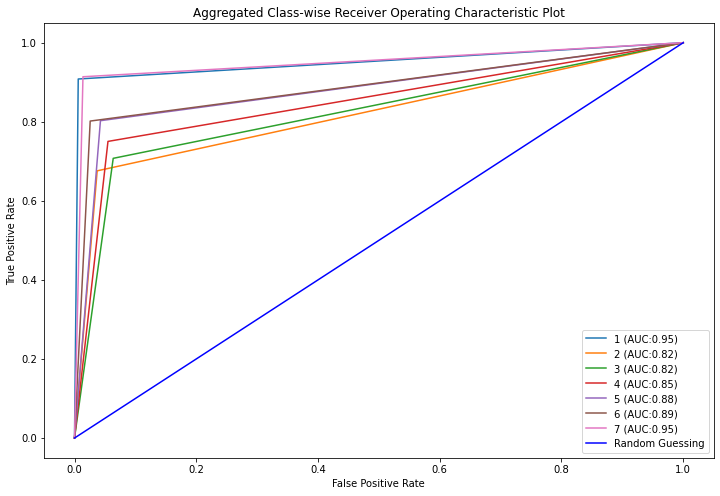

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(set(labels.flatten())):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test_flattened, y_classified))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('Aggregated Class-wise Receiver Operating Characteristic Plot')
plt.savefig("auc.png")
plt.show()

## 3.4. Exporting the Model

We can export the model to `HDF5` format designed to store large amounts of information. More info:
* [Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_Data_Format)
* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/keras/save_and_load#hdf5_format)

In [ ]:
model.save('UX_Regression.h5')

## 3.5. XGB Method
For comparison, we try implementing XGB.

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.59      0.92      0.72       462
         2.0       0.65      0.59      0.62       482
         3.0       0.63      0.50      0.56       510
         4.0       0.59      0.45      0.51       517
         5.0       0.51      0.52      0.52       467
         6.0       0.60      0.62      0.61       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.62      3360
   macro avg       0.63      0.63      0.62      3360
weighted avg       0.63      0.62      0.62      3360

Confusion Matrix: 
 [[423  19   2   1   7  10   0]
 [ 68 285  51  22  26  27   3]
 [ 64  62 256  75  26  27   0]
 [ 69  25  55 233 117  18   0]
 [ 53   7  20  43 243 101   0]
 [ 19  18   8  11  39 292  83]
 [ 15  21  13   9  14  12 368]]
Accuracy Score : 0.625
Precision Score : 0.6267646482838946
Recall Score : 0.625
F1 Score : 0.6183646126348158
(3360, 7) (3360,

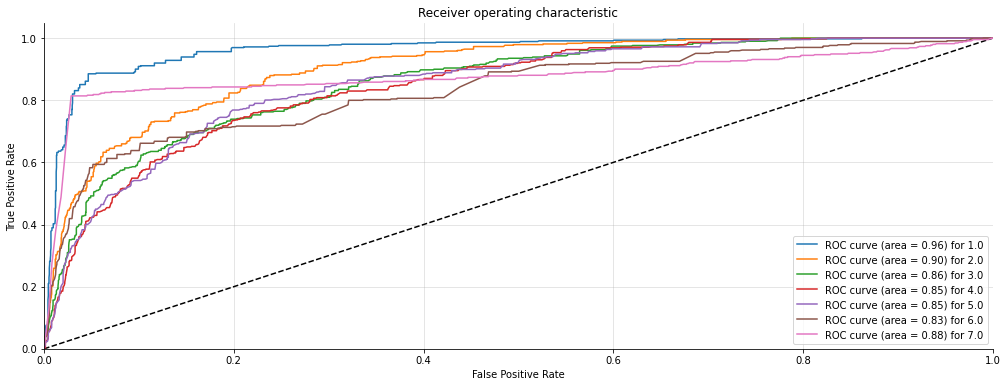

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.61      0.91      0.73       463
         2.0       0.66      0.57      0.61       485
         3.0       0.63      0.50      0.56       501
         4.0       0.59      0.51      0.55       515
         5.0       0.62      0.53      0.57       460
         6.0       0.66      0.76      0.71       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.66      3360
   macro avg       0.67      0.67      0.66      3360
weighted avg       0.66      0.66      0.66      3360

Confusion Matrix: 
 [[423  21   2   6   6   5   0]
 [ 72 278  56  26  19  31   3]
 [ 57  53 250  91  19  30   1]
 [ 51  27  49 261  94  33   0]
 [ 55  14  23  39 246  83   0]
 [ 28  12  12  15   8 366  43]
 [ 12  16   5   4   4   3 408]]
Accuracy Score : 0.6642857142857143
Precision Score : 0.6645856220026266
Recall Score : 0.6642857142857143
F1 Score : 0.6572114286447

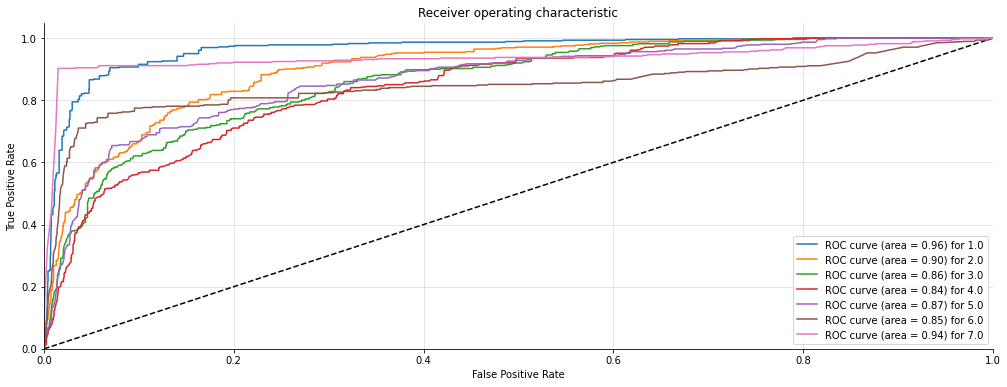

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.62      0.92      0.74       462
         2.0       0.68      0.60      0.64       482
         3.0       0.61      0.49      0.55       506
         4.0       0.58      0.48      0.53       526
         5.0       0.52      0.51      0.52       458
         6.0       0.57      0.61      0.59       475
         7.0       0.82      0.83      0.82       451

    accuracy                           0.63      3360
   macro avg       0.63      0.63      0.63      3360
weighted avg       0.63      0.63      0.62      3360

Confusion Matrix: 
 [[425  14   2   5   6  10   0]
 [ 64 289  50  22  23  30   4]
 [ 55  56 250  92  18  34   1]
 [ 55  24  58 253 110  26   0]
 [ 52   6  20  42 232 106   0]
 [ 22  18  16  13  40 289  77]
 [ 14  18  13   9  13  10 374]]
Accuracy Score : 0.6285714285714286
Precision Score : 0.628039458473222
Recall Score : 0.6285714285714286
F1 Score : 0.622120673

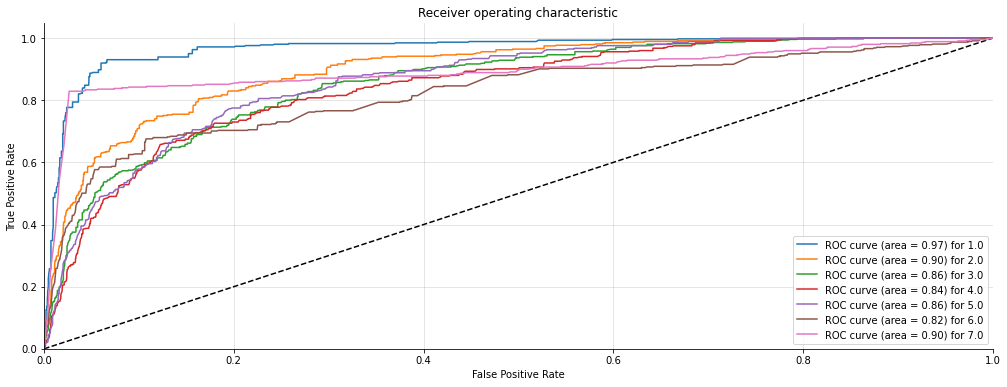

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.61      0.92      0.73       461
         2.0       0.66      0.57      0.61       488
         3.0       0.62      0.51      0.56       506
         4.0       0.57      0.47      0.51       516
         5.0       0.54      0.50      0.52       456
         6.0       0.60      0.66      0.63       471
         7.0       0.80      0.79      0.80       462

    accuracy                           0.63      3360
   macro avg       0.63      0.63      0.62      3360
weighted avg       0.63      0.63      0.62      3360

Confusion Matrix: 
 [[422  15   1   1   6  16   0]
 [ 78 277  54  33  25  18   3]
 [ 54  57 259  88  18  29   1]
 [ 56  27  52 242 115  24   0]
 [ 48   5  22  42 230 109   0]
 [ 17  16  13   9  20 310  86]
 [ 21  25  18  12  12   9 365]]
Accuracy Score : 0.6264880952380952
Precision Score : 0.6266018147345991
Recall Score : 0.6264880952380952
F1 Score : 0.6200454312609

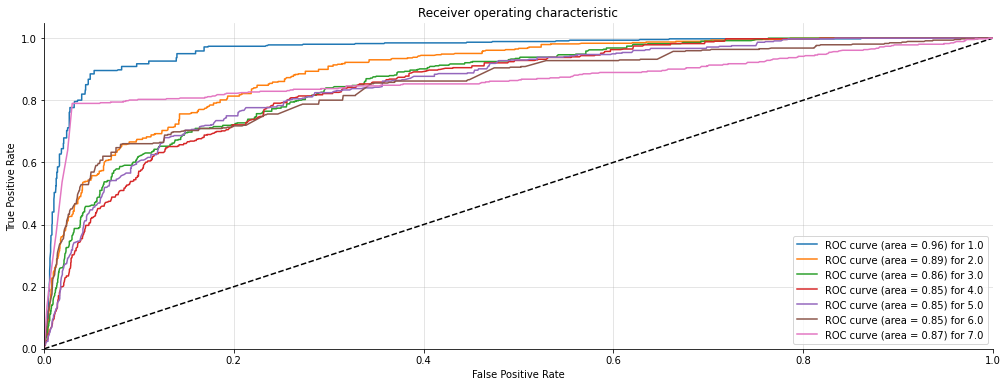

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.68      0.93      0.79       463
         2.0       0.67      0.63      0.65       491
         3.0       0.67      0.55      0.61       487
         4.0       0.77      0.61      0.68       518
         5.0       0.81      0.72      0.76       487
         6.0       0.76      0.92      0.83       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.76      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.76      0.76      0.75      3360

Confusion Matrix: 
 [[432  16   1   6   2   6   0]
 [ 59 309  41  20  28  34   0]
 [ 53  66 270  51  13  34   0]
 [ 39  38  52 317  37  35   0]
 [ 33  26  37  15 352  24   0]
 [ 17   7   3   2   4 424   5]
 [  0   1   1   0   1   3 446]]
Accuracy Score : 0.7589285714285714
Precision Score : 0.7609898892791083
Recall Score : 0.7589285714285714
F1 Score : 0.75365410934254

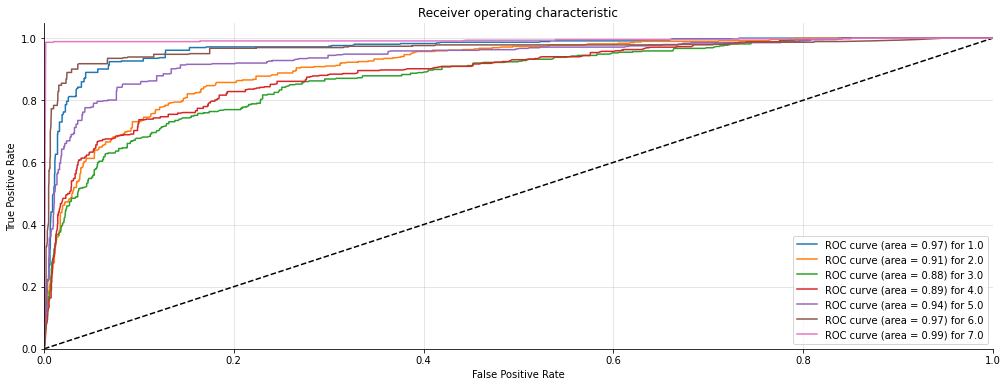

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.65      0.93      0.76       461
         2.0       0.68      0.63      0.66       495
         3.0       0.67      0.57      0.62       490
         4.0       0.75      0.57      0.65       519
         5.0       0.77      0.70      0.73       481
         6.0       0.78      0.91      0.84       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.75      3360
   macro avg       0.76      0.76      0.75      3360
weighted avg       0.75      0.75      0.75      3360

Confusion Matrix: 
 [[428  14   2   5   1  11   0]
 [ 69 312  57  17  15  25   0]
 [ 46  64 281  56  23  20   0]
 [ 40  40  50 297  54  38   0]
 [ 57  20  24  20 336  24   0]
 [ 18   5   3   3   6 425   5]
 [  0   1   1   0   0   1 446]]
Accuracy Score : 0.7514880952380952
Precision Score : 0.7541889089445659
Recall Score : 0.7514880952380952
F1 Score : 0.74

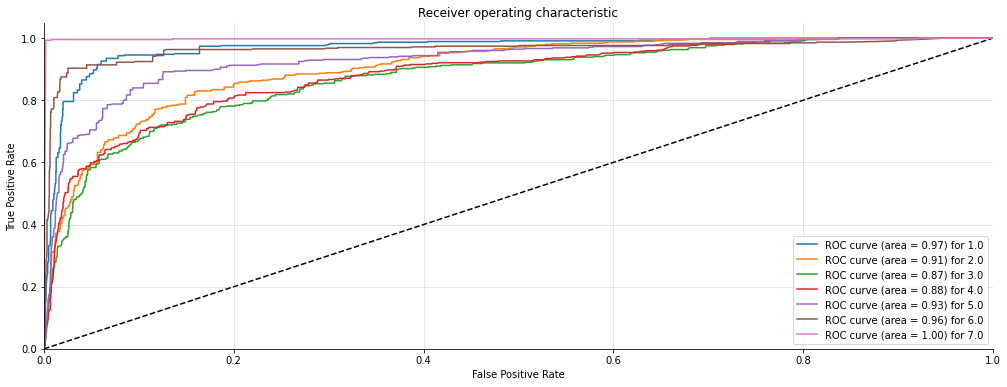

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.68      0.91      0.78       460
         2.0       0.73      0.63      0.68       502
         3.0       0.74      0.70      0.72       474
         4.0       0.77      0.65      0.71       527
         5.0       0.83      0.76      0.80       486
         6.0       0.81      0.94      0.87       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.79      3360
   macro avg       0.80      0.80      0.79      3360
weighted avg       0.79      0.79      0.79      3360

Confusion Matrix: 
 [[417  20   1  10   0  12   0]
 [ 54 316  37  42  33  20   0]
 [ 30  41 330  36  13  24   0]
 [ 45  33  50 342  25  32   0]
 [ 49  17  27   8 370  15   0]
 [ 16   4   0   5   3 431   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7907738095238095
Precision Score : 0.7937881685094696
Recall Score : 0.7907738095238095
F1 Score : 0.7876606

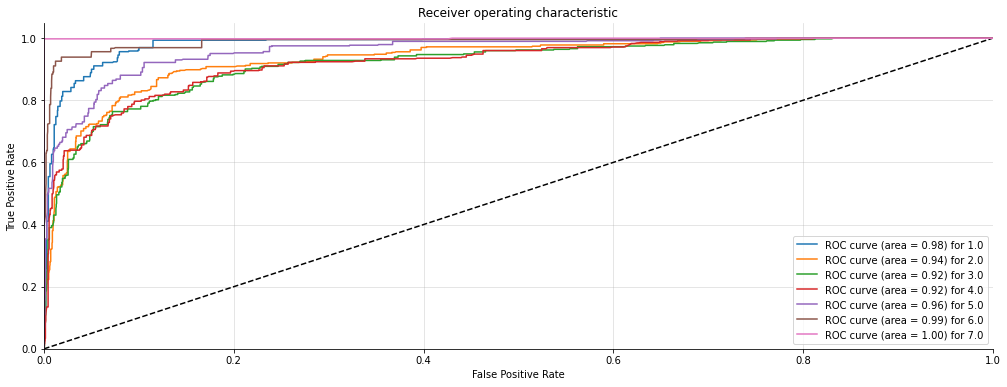

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.67      0.89      0.77       459
         2.0       0.77      0.68      0.72       496
         3.0       0.79      0.73      0.76       478
         4.0       0.84      0.70      0.76       523
         5.0       0.88      0.77      0.82       491
         6.0       0.79      0.95      0.86       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.81      3360
   macro avg       0.82      0.82      0.81      3360
weighted avg       0.82      0.81      0.81      3360

Confusion Matrix: 
 [[408  17   0  12   0  22   0]
 [ 49 339  25  29  31  23   0]
 [ 32  36 349  28  11  22   0]
 [ 40  27  50 365   9  32   0]
 [ 59  17  20   0 377  18   0]
 [ 17   4   0   0   0 441   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.8125
Precision Score : 0.820203401477817
Recall Score : 0.8125
F1 Score : 0.8111458539767165
(3360, 7) (3360, 7)

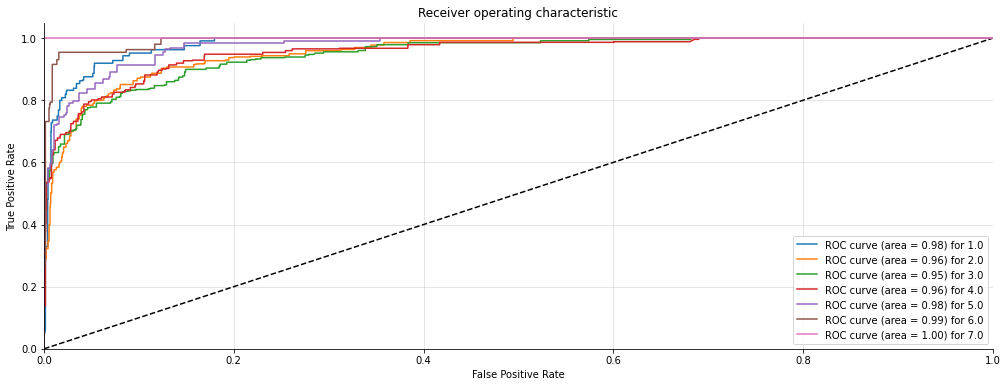

In [ ]:
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def XGBmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    xgb_classifier = XGBClassifier()
    xgb_classifier.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in xgb_classifier.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(xgb_classifier, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  XGBmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

## 3.6. SVM Method

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.49      0.93      0.64       462
         2.0       0.66      0.59      0.62       482
         3.0       0.60      0.50      0.54       510
         4.0       0.61      0.38      0.47       517
         5.0       0.50      0.46      0.48       467
         6.0       0.64      0.57      0.60       470
         7.0       0.79      0.81      0.80       452

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[430   8  10   2   8   4   0]
 [116 282  52  11  11  10   0]
 [ 95  52 253  64  28  14   4]
 [ 80  44  51 194 124  15   9]
 [ 88   9  28  25 217 100   0]
 [ 54  14  11   6  33 267  85]
 [ 20  17  15  14   9   9 368]]
Accuracy Score : 0.5985119047619047
Precision Score : 0.6133278454162681
Recall Score : 0.5985119047619047
F1 Score : 0.5904013

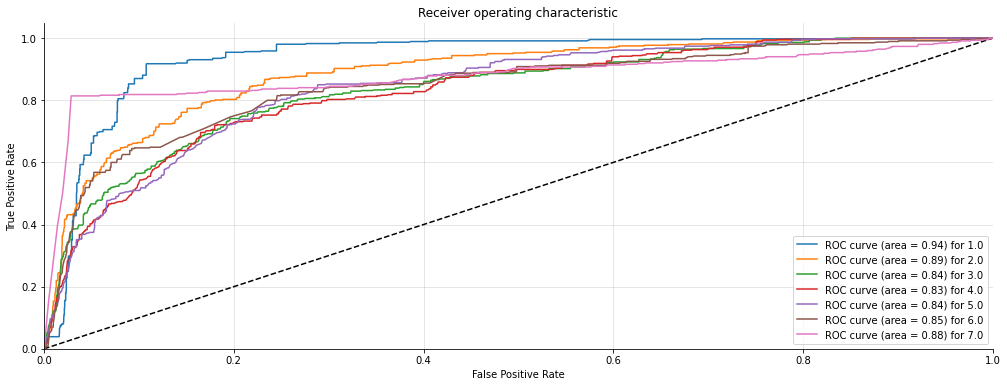

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.49      0.95      0.65       463
         2.0       0.67      0.56      0.61       485
         3.0       0.61      0.48      0.54       501
         4.0       0.64      0.39      0.49       515
         5.0       0.57      0.49      0.53       460
         6.0       0.67      0.68      0.67       484
         7.0       0.89      0.90      0.90       452

    accuracy                           0.63      3360
   macro avg       0.65      0.64      0.63      3360
weighted avg       0.65      0.63      0.62      3360

Confusion Matrix: 
 [[438   9  10   1   1   4   0]
 [114 274  46  11  21  19   0]
 [ 89  50 241  73  26  19   3]
 [ 84  41  48 202 103  34   3]
 [ 91  12  34  12 225  86   0]
 [ 58  15  14   9  14 330  44]
 [ 17  10   4   6   4   3 408]]
Accuracy Score : 0.6303571428571428
Precision Score : 0.6471390787232817
Recall Score : 0.6303571428571428
F1 Score : 0.6220405499637

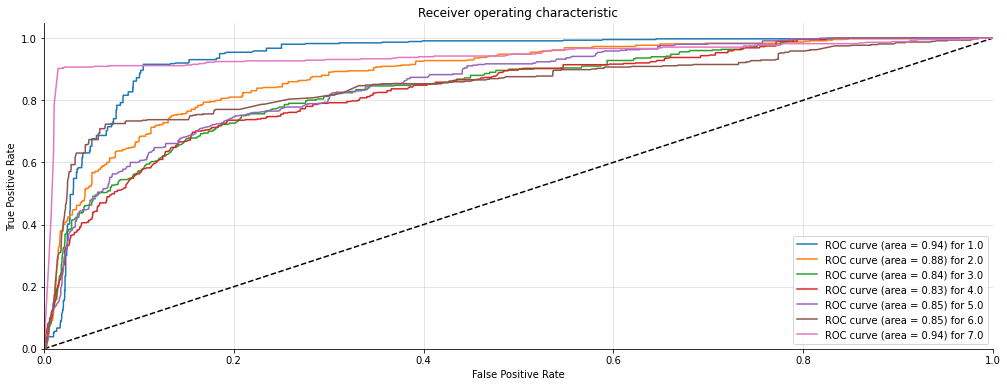

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.49      0.93      0.64       462
         2.0       0.66      0.58      0.62       482
         3.0       0.60      0.49      0.54       506
         4.0       0.62      0.37      0.47       526
         5.0       0.50      0.47      0.48       458
         6.0       0.61      0.55      0.58       475
         7.0       0.80      0.83      0.82       451

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[431   8  11   1   7   4   0]
 [115 281  54  11   8  13   0]
 [ 91  52 250  65  29  15   4]
 [ 82  46  48 197 126  18   9]
 [ 85   8  23  20 214 108   0]
 [ 57  15  14  12  36 262  79]
 [ 20  16  14  10  10   7 374]]
Accuracy Score : 0.5979166666666667
Precision Score : 0.6127317420044573
Recall Score : 0.5979166666666667
F1 Score : 0.58945502

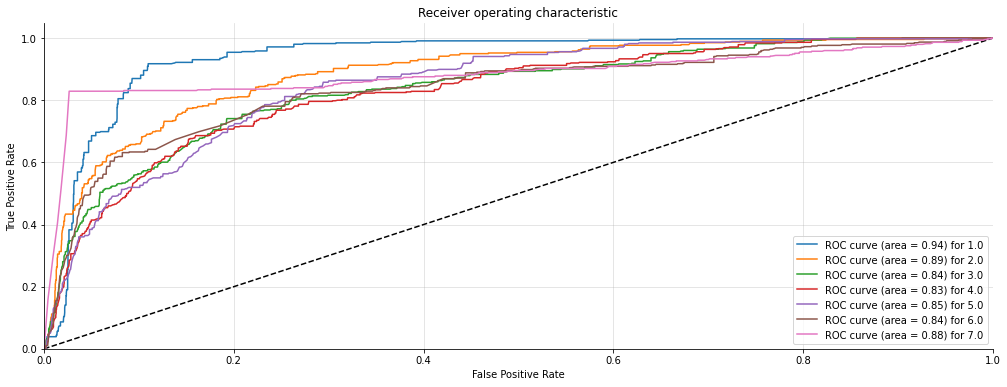

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.49      0.93      0.64       461
         2.0       0.66      0.58      0.62       488
         3.0       0.60      0.48      0.54       506
         4.0       0.62      0.39      0.48       516
         5.0       0.50      0.47      0.49       456
         6.0       0.62      0.57      0.60       471
         7.0       0.79      0.79      0.79       462

    accuracy                           0.60      3360
   macro avg       0.61      0.60      0.59      3360
weighted avg       0.61      0.60      0.59      3360

Confusion Matrix: 
 [[430   8   9   1   9   4   0]
 [118 284  54   9  11  12   0]
 [ 89  55 245  70  30  13   4]
 [ 81  38  45 201 122  20   9]
 [ 84   9  22  22 214 105   0]
 [ 53  15  12   6  31 268  86]
 [ 27  20  19  14   8   7 367]]
Accuracy Score : 0.5979166666666667
Precision Score : 0.6136764274198697
Recall Score : 0.5979166666666667
F1 Score : 0.5904861504080

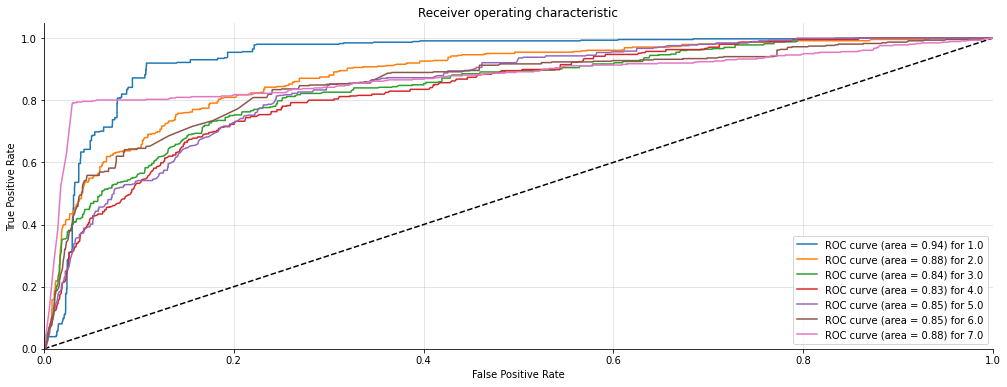

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.52      0.95      0.67       463
         2.0       0.67      0.57      0.62       491
         3.0       0.66      0.53      0.59       487
         4.0       0.80      0.52      0.63       518
         5.0       0.74      0.59      0.66       487
         6.0       0.77      0.85      0.81       462
         7.0       0.96      0.99      0.97       452

    accuracy                           0.71      3360
   macro avg       0.73      0.71      0.71      3360
weighted avg       0.73      0.71      0.70      3360

Confusion Matrix: 
 [[440   8   8   0   3   4   0]
 [117 282  44  10  19  19   0]
 [ 86  50 258  46  25  19   3]
 [ 58  57  38 269  50  35  11]
 [103  14  36   8 287  39   0]
 [ 50   7   3   2   3 392   5]
 [  0   0   1   1   1   3 446]]
Accuracy Score : 0.7065476190476191
Precision Score : 0.7311031448152053
Recall Score : 0.7065476190476191
F1 Score : 0.70206653916012

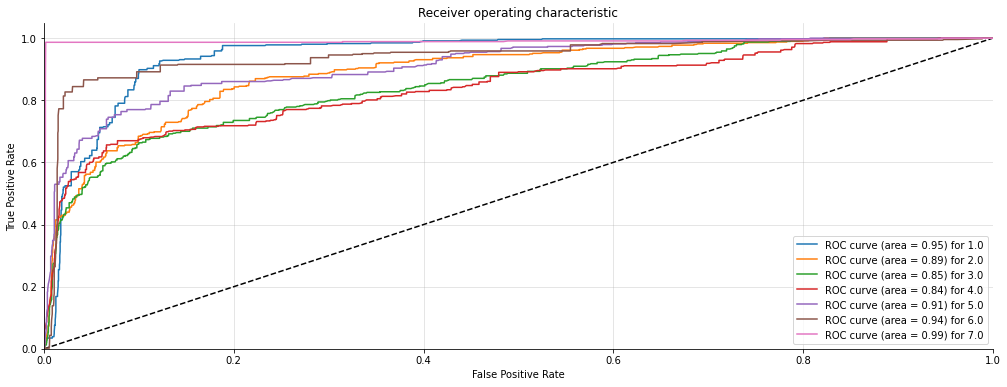

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.51      0.95      0.67       461
         2.0       0.68      0.56      0.61       495
         3.0       0.66      0.53      0.59       490
         4.0       0.79      0.51      0.62       519
         5.0       0.74      0.58      0.65       481
         6.0       0.76      0.86      0.81       465
         7.0       0.96      0.99      0.98       449

    accuracy                           0.70      3360
   macro avg       0.73      0.71      0.70      3360
weighted avg       0.73      0.70      0.70      3360

Confusion Matrix: 
 [[438   8   8   0   2   5   0]
 [118 279  44  10  19  25   0]
 [ 84  56 262  41  20  24   3]
 [ 66  56  41 263  50  32  11]
 [103   8  38  16 277  39   0]
 [ 42   6   3   2   6 401   5]
 [  0   0   1   1   0   1 446]]
Accuracy Score : 0.7041666666666667
Precision Score : 0.727877467320976
Recall Score : 0.7041666666666667
F1 Score : 0.698

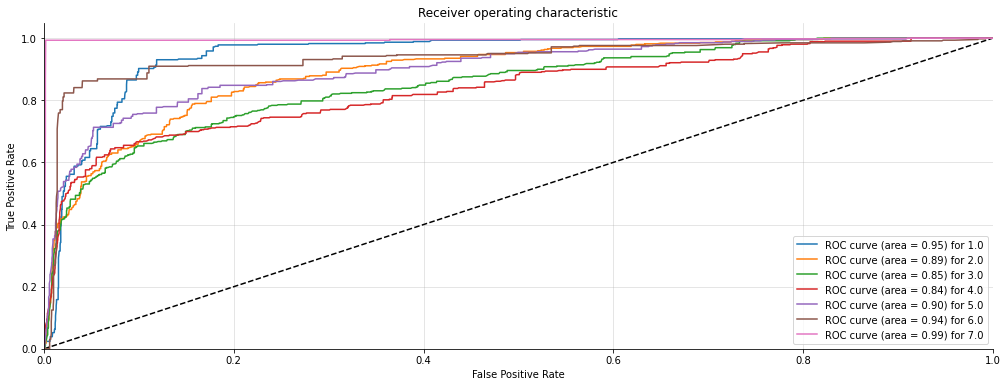

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.51      0.92      0.66       460
         2.0       0.78      0.61      0.68       502
         3.0       0.77      0.64      0.70       474
         4.0       0.86      0.58      0.69       527
         5.0       0.79      0.67      0.73       486
         6.0       0.78      0.88      0.83       459
         7.0       0.98      1.00      0.99       452

    accuracy                           0.75      3360
   macro avg       0.78      0.76      0.75      3360
weighted avg       0.78      0.75      0.75      3360

Confusion Matrix: 
 [[425   3   6   6   9  11   0]
 [116 304  34  15  15  17   1]
 [ 80  38 303  17  17  16   3]
 [ 67  35  39 305  43  35   3]
 [ 99   6  10  11 327  33   0]
 [ 50   4   0   0   2 403   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.7494047619047619
Precision Score : 0.7838346619383489
Recall Score : 0.7494047619047619
F1 Score : 0.7503682

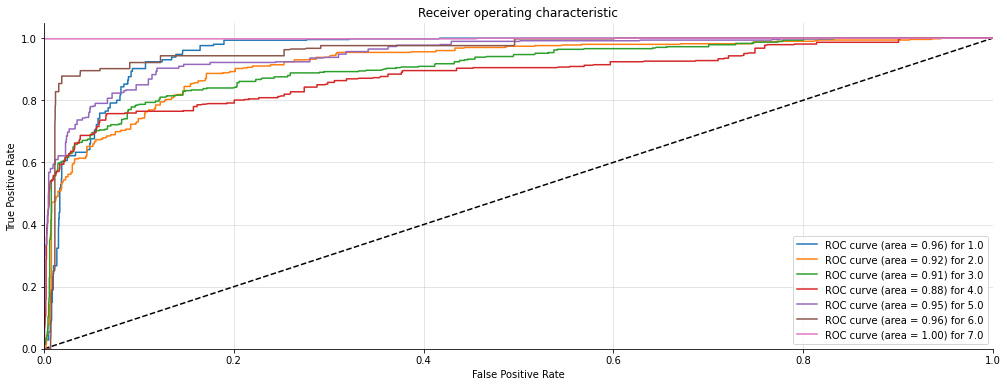

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.52      0.92      0.66       459
         2.0       0.80      0.65      0.72       496
         3.0       0.81      0.68      0.74       478
         4.0       0.94      0.62      0.74       523
         5.0       0.81      0.69      0.75       491
         6.0       0.81      0.89      0.84       462
         7.0       0.97      1.00      0.98       451

    accuracy                           0.77      3360
   macro avg       0.81      0.78      0.78      3360
weighted avg       0.81      0.77      0.78      3360

Confusion Matrix: 
 [[421   0  10   7   9  11   1]
 [115 324  22   7  12  16   0]
 [ 74  38 326   4  19  14   3]
 [ 55  35  32 323  38  30  10]
 [102   6  10   4 341  28   0]
 [ 49   4   0   0   0 409   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7723214285714286
Precision Score : 0.8094835206039098
Recall Score : 0.7723214285714286
F1 Score : 0.77528080000

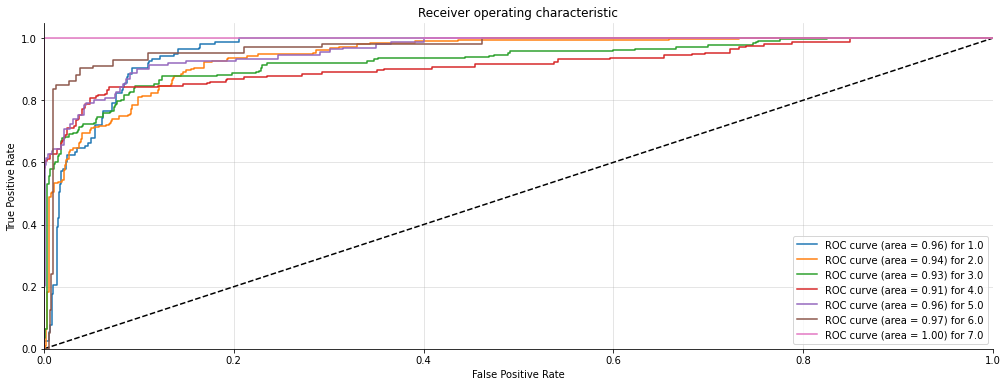

In [26]:
def SVMmodel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    svc = SVC( probability=True)
    svc.fit(X_train, y_train)

    # predictions over test set
    predictions=[round(float(x)) for x in svc.predict(X_test)]
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))

    plot_multiclass_roc(svc, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  SVMmodel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

## 3.7. Custom-Built Ordinal Classifier

Credit: [Muhammad for Towards Data Science](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)

Ordinal classifier basically does a similar thing to one-hot encoding -- but despite having one value each column, ordinal encoding maps unique binary values for each of our unique classes.

We implement a custom object called `OrdinalClassifier` built on top of any `sklearn` model that supports the `predict_proba()` function; ranging from Naive Bayes to decision trees.

Last implementation, we deduced the labels by one, from `[1,2,3,4,5,6,7]` to `[0,1,2,3,4,5,6]` due to the nature of zero-indexing of standard sklearn library. But this doesn't work if the labels aren't ranging fully from 1 to 7 -- could be 2 to 6 or 2 to 7 instead.

So the solution is to change the overall behavior of the `OrdinalClassifier` object to take maximum class (e.g. 7) and minimum class (e.g. 2 or 3) into consideration. From there, we simulate the `np.argmax()` function to be added the minimum class before being returned. We also add the minimum class as an index towards `self.clfs` dictionary when adding new value, so we don't need to deduce the labels by hand. In other words, labels stay as-is instead of being deduced by 1 :)

This also changes how the approach for ordinal encoding works -- instead of `k - 1` like the author's original implementation, we feed `k` numbers of encoding because our labels are already one-indexed.

Keep in mind that the `predict_proba()` function does not yet implement this change, because it's only a wrapper function before eventually calling `predict()` in which we care the most about the result. 

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.70      0.90      0.79       462
         2.0       0.57      0.58      0.57       482
         3.0       0.49      0.50      0.50       510
         4.0       0.51      0.42      0.46       517
         5.0       0.48      0.44      0.46       467
         6.0       0.64      0.60      0.62       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.60      3360
   macro avg       0.60      0.61      0.60      3360
weighted avg       0.60      0.60      0.60      3360

Confusion Matrix: 
 [[418  23  13   3   0   5   0]
 [ 46 278  68  34  40  13   3]
 [ 37  77 257  89  30  20   0]
 [ 38  46  95 218 107  13   0]
 [ 33  25  42  59 206 102   0]
 [ 10  20  26   9  39 283  83]
 [ 12  23  19  13  10   7 368]]
Accuracy Score : 0.6035714285714285
Precision Score : 0.5964362980917086
Recall Score : 0.6035714285714285
F1 Score : 0.5974012

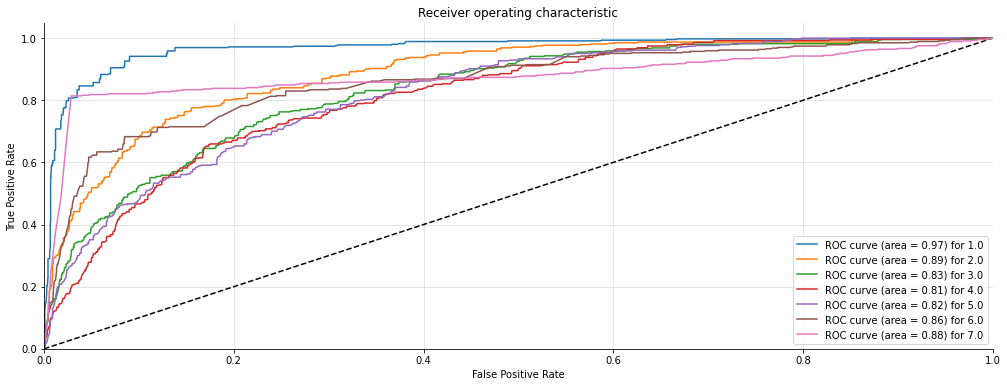

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.70      0.93      0.80       463
         2.0       0.55      0.52      0.53       485
         3.0       0.52      0.51      0.51       501
         4.0       0.51      0.42      0.46       515
         5.0       0.53      0.46      0.49       460
         6.0       0.72      0.76      0.74       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.64      3360
   macro avg       0.63      0.64      0.63      3360
weighted avg       0.63      0.64      0.63      3360

Confusion Matrix: 
 [[430  17   3   2   2   9   0]
 [ 51 252  82  44  39  17   0]
 [ 32  78 256  84  35  16   0]
 [ 41  52  84 215  98  25   0]
 [ 46  28  41  57 213  75   0]
 [  6  15  25  13  13 369  43]
 [ 11  16   4   7   3   3 408]]
Accuracy Score : 0.637797619047619
Precision Score : 0.6281276531072362
Recall Score : 0.637797619047619
F1 Score : 0.629526789974699

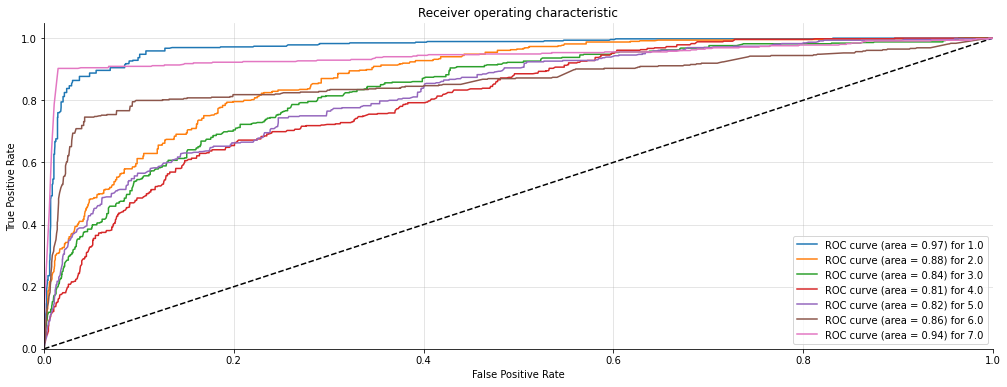

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.64      0.89      0.74       462
         2.0       0.55      0.49      0.52       482
         3.0       0.49      0.48      0.49       506
         4.0       0.49      0.43      0.46       526
         5.0       0.48      0.43      0.45       458
         6.0       0.60      0.59      0.60       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.59      3360
   macro avg       0.58      0.59      0.58      3360
weighted avg       0.58      0.59      0.58      3360

Confusion Matrix: 
 [[409  29   8  11   0   5   0]
 [ 59 238  76  53  34  22   0]
 [ 51  65 244  97  26  23   0]
 [ 53  39  86 228 100  20   0]
 [ 42  24  35  55 196 106   0]
 [ 13  17  32  14  42 280  77]
 [ 11  23  15  11   9   8 374]]
Accuracy Score : 0.5860119047619048
Precision Score : 0.5790818035944018
Recall Score : 0.5860119047619048
F1 Score : 0.57919376

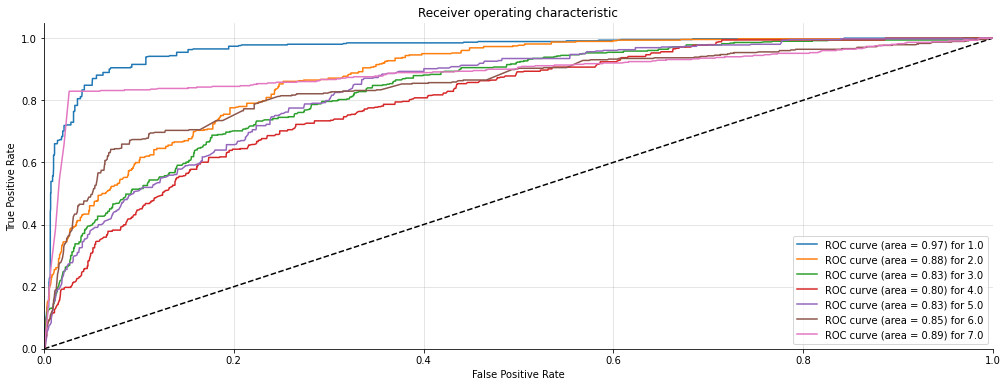

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.69      0.92      0.79       461
         2.0       0.56      0.55      0.55       488
         3.0       0.52      0.51      0.51       506
         4.0       0.52      0.42      0.46       516
         5.0       0.47      0.44      0.46       456
         6.0       0.63      0.63      0.63       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.60      3360
   macro avg       0.60      0.61      0.60      3360
weighted avg       0.60      0.60      0.60      3360

Confusion Matrix: 
 [[422  29   3   2   0   5   0]
 [ 42 267  76  45  37  21   0]
 [ 35  69 258  86  36  22   0]
 [ 48  40  88 216 109  15   0]
 [ 39  26  36  47 202 106   0]
 [  9  21  20   7  29 299  86]
 [ 18  25  19  16  13   6 365]]
Accuracy Score : 0.6038690476190476
Precision Score : 0.5966827125210435
Recall Score : 0.6038690476190476
F1 Score : 0.5971980905914

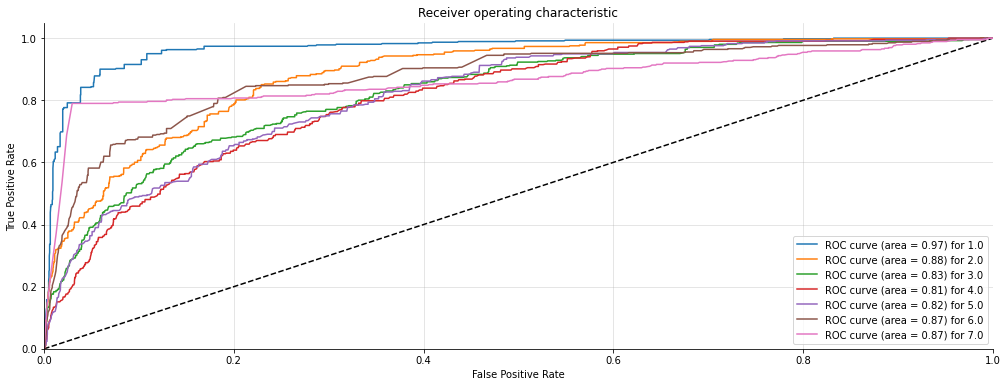

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.75      0.89      0.81       463
         2.0       0.59      0.56      0.57       491
         3.0       0.58      0.52      0.55       487
         4.0       0.61      0.54      0.57       518
         5.0       0.70      0.61      0.65       487
         6.0       0.75      0.92      0.82       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.71      3360
   macro avg       0.71      0.72      0.71      3360
weighted avg       0.71      0.71      0.71      3360

Confusion Matrix: 
 [[411  30   2  12   1   7   0]
 [ 34 276  66  58  31  26   0]
 [ 34  67 255  74  29  28   0]
 [ 30  51  70 282  53  32   0]
 [ 38  39  31  35 298  46   0]
 [  2   6  12   2  12 423   5]
 [  0   0   1   0   1   4 446]]
Accuracy Score : 0.7116071428571429
Precision Score : 0.7050526118960313
Recall Score : 0.7116071428571429
F1 Score : 0.70534706195958

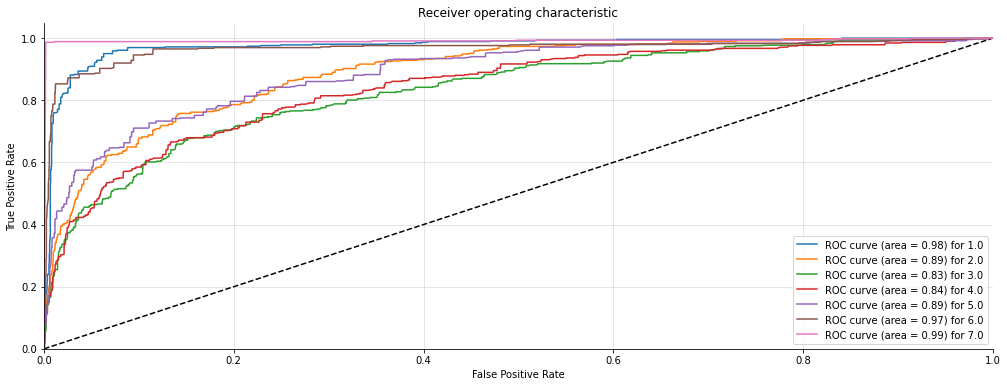

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.73      0.87      0.79       461
         2.0       0.57      0.51      0.54       495
         3.0       0.55      0.53      0.54       490
         4.0       0.66      0.54      0.59       519
         5.0       0.67      0.63      0.65       481
         6.0       0.77      0.93      0.84       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.71      3360
   macro avg       0.70      0.71      0.71      3360
weighted avg       0.70      0.71      0.70      3360

Confusion Matrix: 
 [[403  34   4  10   5   5   0]
 [ 47 252  84  41  43  28   0]
 [ 44  70 258  56  32  30   0]
 [ 22  51  79 280  62  25   0]
 [ 37  26  34  38 303  43   0]
 [  1   6  12   2   6 433   5]
 [  0   1   0   0   0   2 446]]
Accuracy Score : 0.7068452380952381
Precision Score : 0.6995519305820076
Recall Score : 0.7068452380952381
F1 Score : 0.69

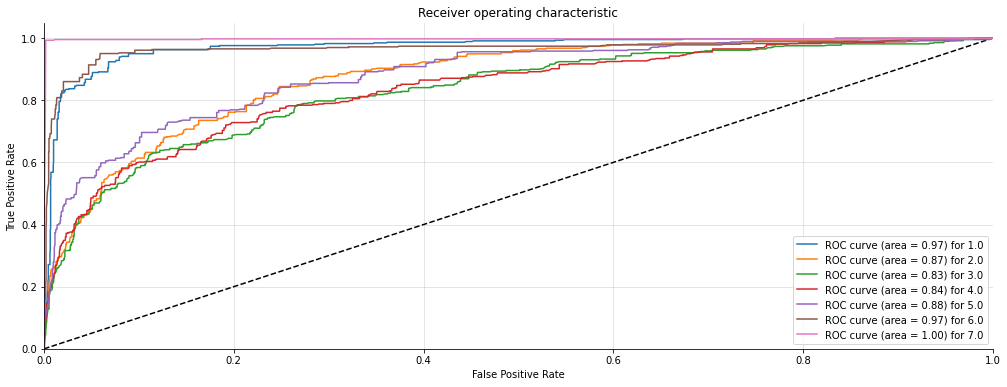

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.75      0.88      0.81       460
         2.0       0.65      0.59      0.62       502
         3.0       0.66      0.59      0.62       474
         4.0       0.70      0.65      0.67       527
         5.0       0.74      0.68      0.71       486
         6.0       0.79      0.95      0.86       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.75      0.76      0.75      3360

Confusion Matrix: 
 [[403  37   1  14   0   5   0]
 [ 33 296  55  47  53  18   0]
 [ 28  59 280  50  28  29   0]
 [ 29  33  61 341  28  35   0]
 [ 43  29  21  33 332  28   0]
 [  0   4   8   0   9 438   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.75625
Precision Score : 0.7517338629793745
Recall Score : 0.75625
F1 Score : 0.7515160223542715
(3360, 7) (3

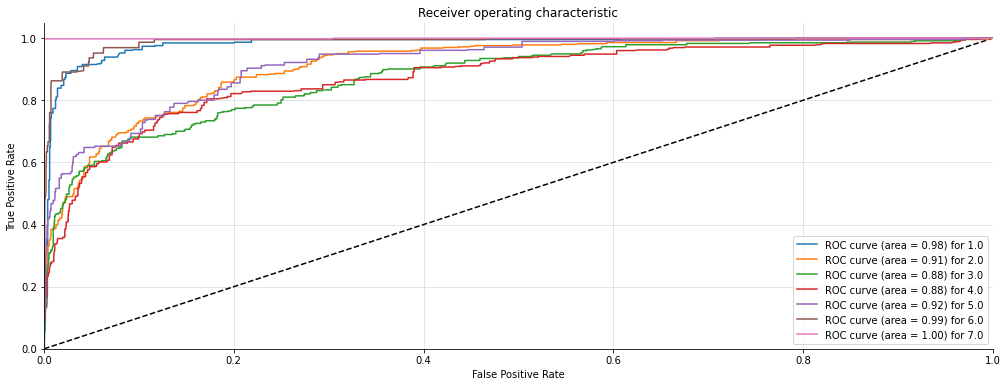

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.73      0.88      0.80       459
         2.0       0.69      0.61      0.65       496
         3.0       0.62      0.58      0.60       478
         4.0       0.73      0.66      0.69       523
         5.0       0.76      0.69      0.72       491
         6.0       0.79      0.93      0.85       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.76      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.76      0.76      0.75      3360

Confusion Matrix: 
 [[405  26   1  11  12   4   0]
 [ 43 303  48  49  33  20   0]
 [ 36  55 278  34  37  38   0]
 [ 28  33  56 347  18  41   0]
 [ 37  15  51  37 337  14   0]
 [  6   4  17   0   6 429   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.7589285714285714
Precision Score : 0.7563893588917855
Recall Score : 0.7589285714285714
F1 Score : 0.75488433228

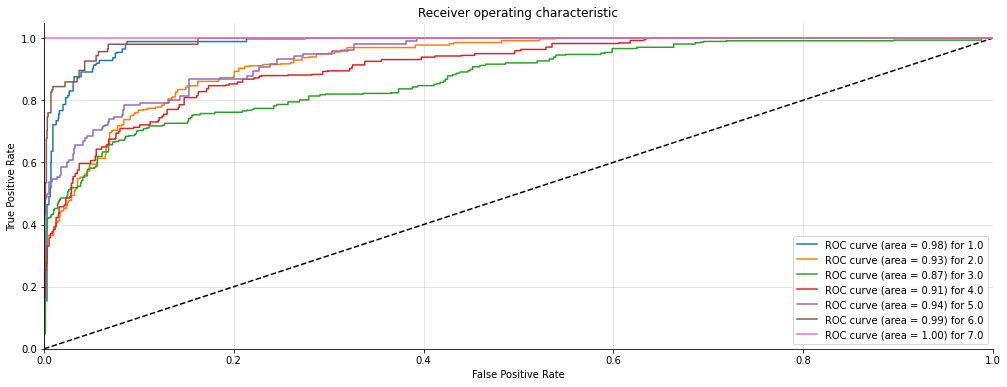

In [27]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        self.max_class = max(self.unique_class)
        self.min_class = min(self.unique_class)
        if self.unique_class.shape[0] > 2:
            # print(self.unique_class.shape[0]) # Uncomment to debug
            for i in range(self.unique_class.shape[0]):
                # for each k ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                
                
                clf.fit(X, binary_y)
                self.clfs[i + self.min_class] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        # print(self.clfs) # Uncomment to debug
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1) + self.min_class

def OrdinalModel(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    clf = OrdinalClassifier(XGBClassifier()) # Using XGB as the placeholder model 
    clf.fit(X_train, y_train)

    # predictions over test set
    predictions = clf.predict(X_test)
    print((classification_report(y_test, predictions)))

    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))

    plot_multiclass_roc(clf, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  OrdinalModel(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))
  #break # Uncomment to debug

# 4. Other Deep Learning Model(s)

## 4.1. Bidirectional LSTM

In [ ]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(2000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

In [31]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 7s 215ms/step - loss: 0.5771 - mae: 0.4547 - val_loss: 0.4988 - val_mae: 0.3689
Epoch 2/100
21/21 [==============================] - 5s 218ms/step - loss: 0.5830 - mae: 0.4618 - val_loss: 0.4999 - val_mae: 0.3749
Epoch 3/100
21/21 [==============================] - 5s 221ms/step - loss: 0.5852 - mae: 0.4619 - val_loss: 0.5001 - val_mae: 0.3728
Epoch 4/100
21/21 [==============================] - 5s 219ms/step - loss: 0.5843 - mae: 0.4600 - val_loss: 0.4990 - val_mae: 0.3676
Epoch 5/100
21/21 [==============================] - 5s 220ms/step - loss: 0.5800 - mae: 0.4564 - val_loss: 0.4985 - val_mae: 0.3686
Epoch 6/100
21/21 [==============================] - 5s 220ms/step - loss: 0.5788 - mae: 0.4566 - val_loss: 0.4992 - val_mae: 0.3701
Epoch 7/100
21/21 [==============================] - 5s 218ms/step - loss: 0.5765 - mae: 0.4552 - val_loss: 0.4984 - val_mae: 0.3659
Epoch 8/100
21/21 [==============================] - 5s 219ms/step - 

### 4.1.1. Interpretation

In [ ]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [ ]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

In [32]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test_flattened[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test_flattened, LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [3, 1, 2, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.97      0.94      0.95      3691
         2.0       0.84      0.77      0.80      3921
         3.0       0.74      0.78      0.76      3952
         4.0       0.78      0.81      0.79      4161
         5.0       0.80      0.84      0.82      3786
         6.0       0.87      0.85      0.86      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.84     26880
   macro avg       0.84      0.84      0.84     26880
weighted avg       0.84      0.84      0.84     26880



## 4.2. BERT [deprecated]

In [33]:
"""!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

to_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
to_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model = hub.KerasLayer(to_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_model(text_test)

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print(f'Training model with {to_handle}')
history = classifier_model.fit(X_train, y_train)"""

"!pip install -q -U tensorflow-text\n!pip install -q tf-models-official\nimport tensorflow_hub as hub\nimport tensorflow_text as text\nfrom official.nlp import optimization  # to create AdamW optimizer\n\nto_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'\nto_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'\nbert_model = hub.KerasLayer(to_preprocess)\n\ntext_test = ['this is such an amazing movie!']\ntext_preprocessed = bert_model(text_test)\n\ndef build_classifier_model():\n  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')\n  preprocessing_layer = hub.KerasLayer(to_preprocess, name='preprocessing')\n  encoder_inputs = preprocessing_layer(text_input)\n  encoder = hub.KerasLayer(to_handle, trainable=True, name='BERT_encoder')\n  outputs = encoder(encoder_inputs)\n  net = outputs['pooled_output']\n  net = tf.keras.layers.Dropout(0.1)(net)\n  net = tf.keras.layers.Dense(1, activation=None, name='classifi

# RBFN

In [36]:

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

In [63]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        print("done")
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.initializers import Initializer
from sklearn.cluster import KMeans


class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


In [64]:
import numpy as np, pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [77]:
model = Sequential()
rbflayer = RBFLayer(100,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(X_train.shape[1],))
model.add(rbflayer)
model.add(Dense(8))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['accuracy'])
model.build(X_train.shape)
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=100)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_17 (ModuleWra (13440, 100)              2100      
_________________________________________________________________
dense_17 (Dense)             (13440, 8)                808       
_________________________________________________________________
activation_17 (Activation)   (13440, 8)                0         
Total params: 2,908
Trainable params: 2,908
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
420/420 [==============================] - 1s 695us/step - loss: 18.9246 - accuracy: 0.0280
Epoch 2/100
420/420 [==============================] - 0s 821us/step - loss: 16.2133 - accuracy: 0.0034
Epoch 3/100
420/420 [==============================] - 0s 764us/step - loss: 13.5310 - accuracy: 0.0069
Epoch 4/100
420/420 [==============================] - 0s 759us/

In [73]:
y_train.shape

(13440, 8)

In [87]:
LSTM_y_pred = model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [[2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [4. 4. 4. 4. 5. 5. 5. 5.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 3. 4. 4.]
 [7. 7. 7. 7. 2. 2. 1. 1.]]
Predicted labels: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       1.00      0.01      0.02      3691
         2.0       0.85      0.01      0.02      3921
         3.0       0.94      0.00      0.01      3952
         4.0       0.16      0.99      0.28      4161
         5.0       0.79      0.04      0.07      3786
         6.0       0.90      0.08      0.15      3748
         7.0       0.91      0.14      0.24      3621

    accuracy                           0.19     26880
   macro avg       0.79      0.18      0.11     26880
weighted avg       0.78      0.19      0.11     268

In [81]:
from sklearn.metrics import classification_report

In [85]:
X_test.shape

(3360, 20)

In [86]:
y_test.shape

(3360, 8)

# Logistic

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.23      0.53      0.32       462
         2.0       0.25      0.16      0.19       482
         3.0       0.21      0.08      0.12       510
         4.0       0.23      0.11      0.15       517
         5.0       0.25      0.16      0.20       467
         6.0       0.24      0.21      0.22       470
         7.0       0.47      0.85      0.60       452

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.25      3360

Confusion Matrix: 
 [[247  35  25   9  32  59  55]
 [168  75  29  45  42  49  74]
 [167  62  42  54  47  75  63]
 [159  53  46  58  75  62  64]
 [173  36  25  47  75  66  45]
 [140  26  25  27  21 101 130]
 [ 26   9   5   8   6  16 382]]
Accuracy Score : 0.2916666666666667
Precision Score : 0.26733790478207264
Recall Score : 0.2916666666666667
F1 Score : 0.253037

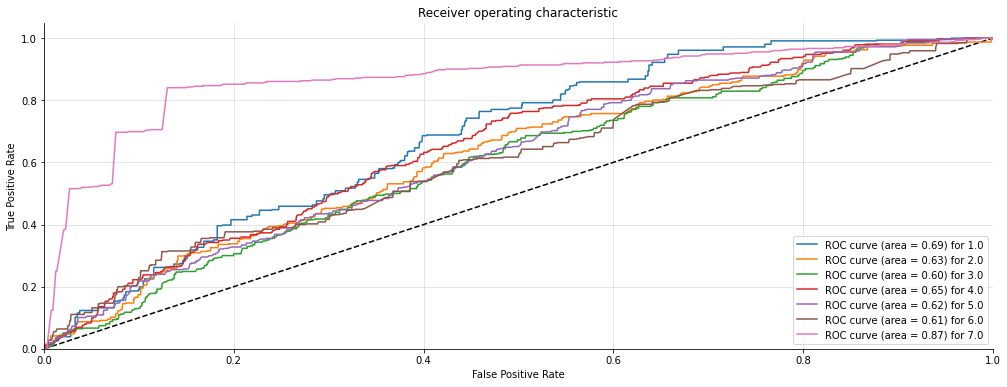

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.25      0.17      0.20       463
         2.0       0.21      0.16      0.18       485
         3.0       0.17      0.10      0.13       501
         4.0       0.23      0.16      0.19       515
         5.0       0.21      0.25      0.23       460
         6.0       0.23      0.32      0.27       484
         7.0       0.52      0.92      0.66       452

    accuracy                           0.29      3360
   macro avg       0.26      0.30      0.27      3360
weighted avg       0.26      0.29      0.26      3360

Confusion Matrix: 
 [[ 78  65  42  32  74  98  74]
 [ 51  79  63  71  78  78  65]
 [ 41  65  50  73  91 120  61]
 [ 39  63  65  83 120  89  56]
 [ 44  64  33  66 117 106  30]
 [ 55  35  34  33  71 153 103]
 [  2   6   2   9   5  13 415]]
Accuracy Score : 0.29017857142857145
Precision Score : 0.25717172973088087
Recall Score : 0.29017857142857145
F1 Score : 0.2610484225

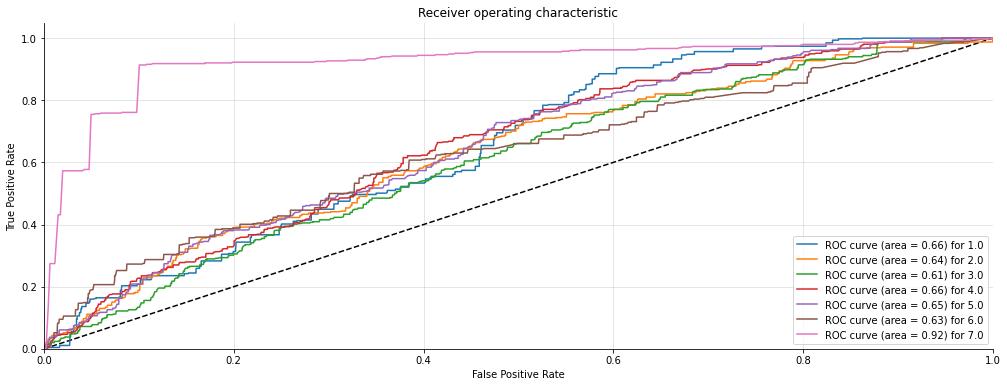

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.22      0.52      0.31       462
         2.0       0.25      0.16      0.19       482
         3.0       0.22      0.09      0.12       506
         4.0       0.26      0.12      0.16       526
         5.0       0.27      0.18      0.21       458
         6.0       0.23      0.20      0.22       475
         7.0       0.47      0.85      0.61       451

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.26      3360

Confusion Matrix: 
 [[239  35  30   9  27  61  61]
 [169  75  29  36  47  52  74]
 [167  63  44  53  45  76  58]
 [164  56  45  62  69  64  66]
 [167  36  24  45  81  64  41]
 [142  27  25  30  27  97 127]
 [ 30   6   6   5   8  13 383]]
Accuracy Score : 0.29196428571428573
Precision Score : 0.27157232134727377
Recall Score : 0.29196428571428573
F1 Score : 0.25521

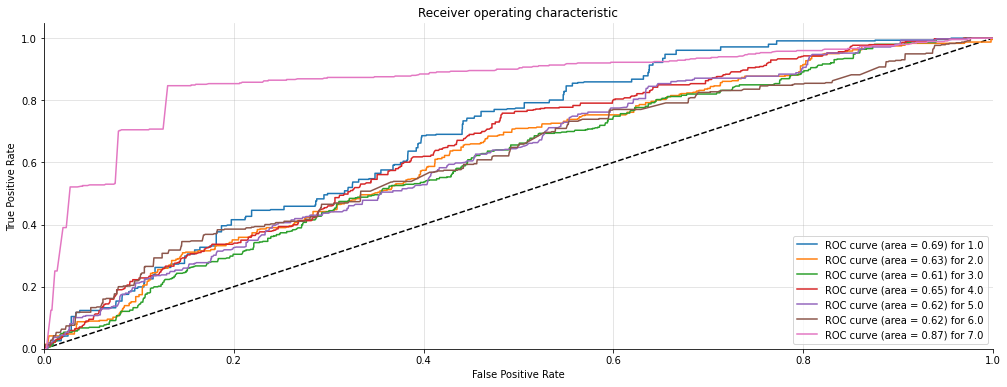

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.22      0.52      0.31       461
         2.0       0.24      0.15      0.18       488
         3.0       0.24      0.10      0.14       506
         4.0       0.24      0.10      0.14       516
         5.0       0.25      0.17      0.20       456
         6.0       0.24      0.21      0.23       471
         7.0       0.47      0.81      0.59       462

    accuracy                           0.29      3360
   macro avg       0.27      0.30      0.26      3360
weighted avg       0.27      0.29      0.25      3360

Confusion Matrix: 
 [[240  35  30   9  27  59  61]
 [174  72  30  37  51  49  75]
 [162  64  52  51  44  71  62]
 [164  57  44  51  80  58  62]
 [173  34  26  35  78  71  39]
 [136  31  25  23  23 101 132]
 [ 36  10   6  10   7  17 376]]
Accuracy Score : 0.28869047619047616
Precision Score : 0.269332618918738
Recall Score : 0.28869047619047616
F1 Score : 0.252908867087

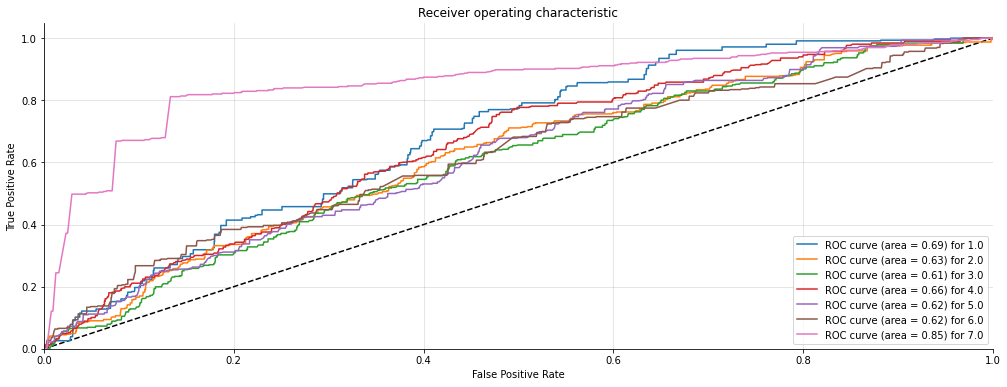

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.24      0.12      0.16       463
         2.0       0.23      0.18      0.20       491
         3.0       0.20      0.13      0.16       487
         4.0       0.27      0.16      0.20       518
         5.0       0.27      0.38      0.32       487
         6.0       0.28      0.47      0.35       462
         7.0       0.67      0.99      0.80       452

    accuracy                           0.34      3360
   macro avg       0.31      0.35      0.31      3360
weighted avg       0.30      0.34      0.31      3360

Confusion Matrix: 
 [[ 56  70  35  40  81 126  55]
 [ 49  88  58  66  92  96  42]
 [ 29  60  62  56 123 122  35]
 [ 33  68  59  82 140 109  27]
 [ 20  69  62  26 186 102  22]
 [ 45  30  28  33  68 216  42]
 [  1   1   0   1   1   1 447]]
Accuracy Score : 0.33839285714285716
Precision Score : 0.3048135660538455
Recall Score : 0.33839285714285716
F1 Score : 0.306074437782

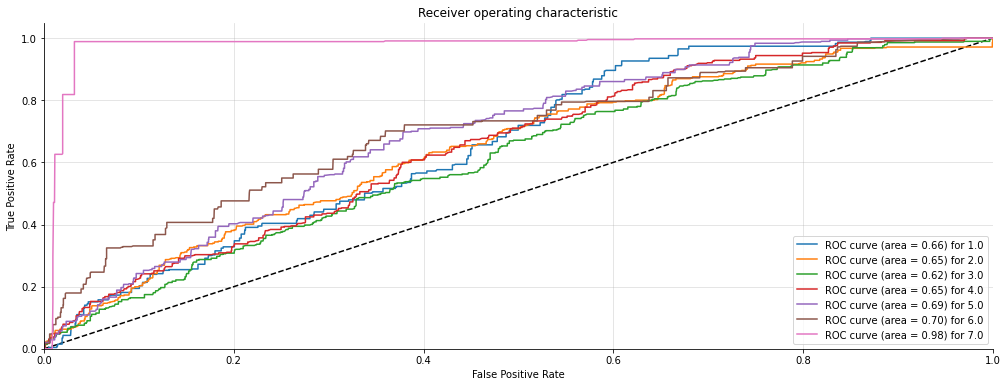

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.22      0.11      0.15       461
         2.0       0.21      0.16      0.18       495
         3.0       0.19      0.12      0.15       490
         4.0       0.26      0.15      0.19       519
         5.0       0.23      0.33      0.27       481
         6.0       0.26      0.42      0.32       465
         7.0       0.65      1.00      0.79       449

    accuracy                           0.32      3360
   macro avg       0.29      0.33      0.29      3360
weighted avg       0.29      0.32      0.29      3360

Confusion Matrix: 
 [[ 53  69  36  37  86 126  54]
 [ 46  80  60  66 109  91  43]
 [ 31  50  61  59 129 125  35]
 [ 30  76  56  78 145  98  36]
 [ 28  74  58  34 159 107  21]
 [ 47  30  45  26  73 196  48]
 [  1   0   0   0   0   1 447]]
Accuracy Score : 0.3196428571428571
Precision Score : 0.28647888472668864
Recall Score : 0.3196428571428571
F1 Score : 0.2

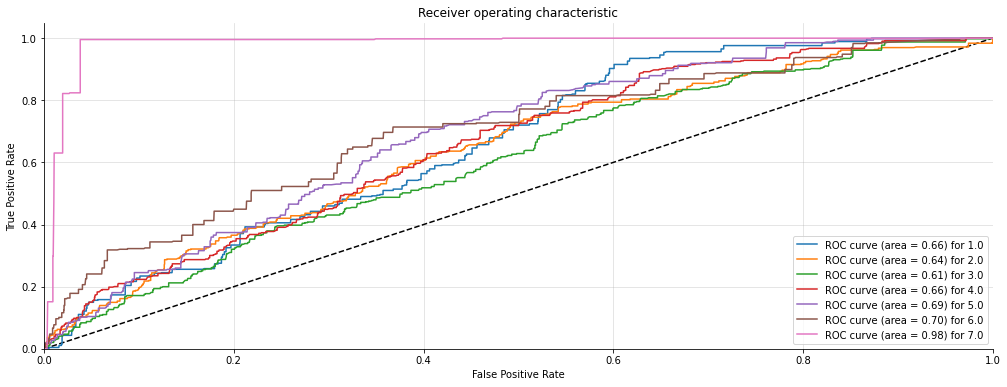

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.20      0.12      0.15       460
         2.0       0.22      0.14      0.17       502
         3.0       0.18      0.14      0.16       474
         4.0       0.28      0.18      0.22       527
         5.0       0.23      0.31      0.26       486
         6.0       0.27      0.45      0.34       459
         7.0       0.71      1.00      0.83       452

    accuracy                           0.33      3360
   macro avg       0.30      0.33      0.30      3360
weighted avg       0.30      0.33      0.30      3360

Confusion Matrix: 
 [[ 56  60  44  35  97 118  50]
 [ 48  72  69  72 104 104  33]
 [ 29  48  65  58 114 134  26]
 [ 40  56  63  95 147 104  22]
 [ 44  54  68  49 152  99  20]
 [ 61  31  44  27  55 205  36]
 [  1   0   0   0   0   0 451]]
Accuracy Score : 0.3261904761904762
Precision Score : 0.2959259137502131
Recall Score : 0.3261904761904762
F1 Score : 0.2987855

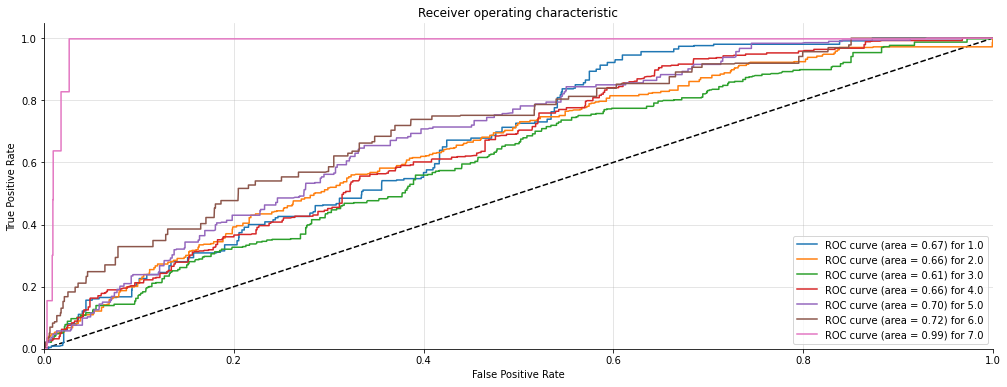

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.24      0.13      0.17       459
         2.0       0.22      0.18      0.19       496
         3.0       0.21      0.14      0.17       478
         4.0       0.29      0.20      0.24       523
         5.0       0.24      0.32      0.27       491
         6.0       0.27      0.43      0.33       462
         7.0       0.71      1.00      0.83       451

    accuracy                           0.34      3360
   macro avg       0.31      0.34      0.32      3360
weighted avg       0.31      0.34      0.31      3360

Confusion Matrix: 
 [[ 58  73  43  31  87 118  49]
 [ 45  87  62  73 106  90  33]
 [ 26  49  69  66 108 133  27]
 [ 28  78  57 105 141  92  22]
 [ 29  76  64  50 156 102  14]
 [ 56  35  36  42  56 200  37]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.3351190476190476
Precision Score : 0.3071036243756023
Recall Score : 0.3351190476190476
F1 Score : 0.30978873850

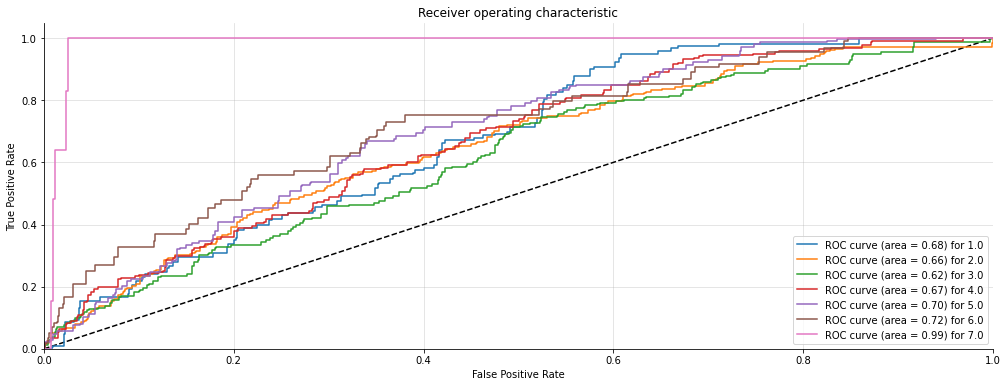

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def Logistic(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  Logistic(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

# NN 2

In [57]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initializer = tf.keras.initializers.RandomNormal(seed=1) # Reproducibility

model = Sequential(name="classifier_NN")
model.add(tf.keras.Input(shape=(X_train.shape[1],))) # Automatically detect features as input nodes
model.add(layers.Dense(512, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'], optimizer = opt)
model.summary()

Model: "classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 512)               10752     
_________________________________________________________________
dense_120 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_123 (Dense)            (None, 128)             

Epoch 1/150
588/588 - 2s - loss: 4.9857 - mae: 1.7357 - val_loss: 4.0903 - val_mae: 1.5950
Epoch 2/150
588/588 - 1s - loss: 2.8322 - mae: 1.3085 - val_loss: 1.9258 - val_mae: 1.0737
Epoch 3/150
588/588 - 1s - loss: 1.9726 - mae: 1.0826 - val_loss: 1.4584 - val_mae: 0.9195
Epoch 4/150
588/588 - 1s - loss: 1.5729 - mae: 0.9615 - val_loss: 1.2279 - val_mae: 0.8253
Epoch 5/150
588/588 - 1s - loss: 1.3984 - mae: 0.8958 - val_loss: 1.4211 - val_mae: 0.9250
Epoch 6/150
588/588 - 1s - loss: 1.2383 - mae: 0.8314 - val_loss: 1.1201 - val_mae: 0.8094
Epoch 7/150
588/588 - 1s - loss: 1.1375 - mae: 0.7859 - val_loss: 0.9090 - val_mae: 0.6800
Epoch 8/150
588/588 - 1s - loss: 1.0887 - mae: 0.7603 - val_loss: 0.9116 - val_mae: 0.6963
Epoch 9/150
588/588 - 1s - loss: 1.0131 - mae: 0.7251 - val_loss: 0.8634 - val_mae: 0.6815
Epoch 10/150
588/588 - 1s - loss: 0.9723 - mae: 0.7018 - val_loss: 0.9405 - val_mae: 0.7159
Epoch 11/150
588/588 - 1s - loss: 0.9400 - mae: 0.6832 - val_loss: 0.9611 - val_mae: 0.70

Epoch 91/150
588/588 - 1s - loss: 0.5451 - mae: 0.4218 - val_loss: 0.5186 - val_mae: 0.3901
Epoch 92/150
588/588 - 1s - loss: 0.5550 - mae: 0.4260 - val_loss: 0.5208 - val_mae: 0.3972
Epoch 93/150
588/588 - 1s - loss: 0.5560 - mae: 0.4277 - val_loss: 0.5093 - val_mae: 0.3638
Epoch 94/150
588/588 - 1s - loss: 0.5437 - mae: 0.4227 - val_loss: 0.5074 - val_mae: 0.3691
Epoch 95/150
588/588 - 1s - loss: 0.5378 - mae: 0.4166 - val_loss: 0.5116 - val_mae: 0.3775
Epoch 96/150
588/588 - 1s - loss: 0.5419 - mae: 0.4209 - val_loss: 0.5142 - val_mae: 0.3644
Epoch 97/150
588/588 - 1s - loss: 0.5473 - mae: 0.4207 - val_loss: 0.5117 - val_mae: 0.3600
Epoch 98/150
588/588 - 1s - loss: 0.5455 - mae: 0.4216 - val_loss: 0.5225 - val_mae: 0.4175
Epoch 99/150
588/588 - 1s - loss: 0.5444 - mae: 0.4174 - val_loss: 0.5159 - val_mae: 0.3744
Epoch 00099: early stopping


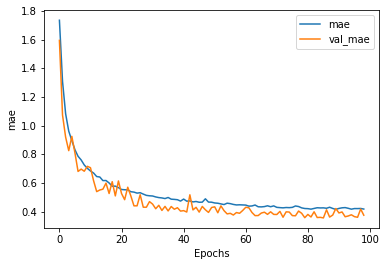

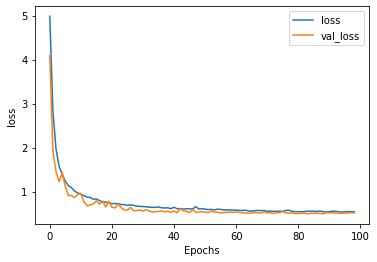

In [58]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
history = model.fit(X_train, y_train, epochs=150, batch_size = 16, validation_split=0.3, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=2)

plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [59]:
scores = model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 4s 1ms/step - loss: 0.5330 - mae: 0.3807
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 53.30%
mae: 38.07%


# LSTM 2

In [115]:
## Callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

## Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(4000, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(64, activation='relu', 
                          
                          # Prevent overfitting
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01), 

                          # Ensuring consistent outputs and not run into potential local optima
                          # Avoid initializing standard normal (mean = 0, std = 1) to reach faster convergence and less initial loss.
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=42)
                          
                          ),
     
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='linear')
])
LSTM_model.summary()

LSTM_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer= opt, metrics=['mae'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 128)         640000    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_168 (Dense)            (None, 64)                16448     
_________________________________________________________________
dropout_92 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 8)                 520       
Total params: 920,136
Trainable params: 920,136
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size = 512, validation_split=0.2, 
                    callbacks = [es], # Call checkpoint variable if neccessary
                    verbose=1)

Epoch 1/100
21/21 [==============================] - 8s 283ms/step - loss: 15.3128 - mae: 3.2975 - val_loss: 5.7338 - val_mae: 1.9351
Epoch 2/100
21/21 [==============================] - 5s 253ms/step - loss: 4.9238 - mae: 1.8135 - val_loss: 3.4853 - val_mae: 1.5283
Epoch 3/100
21/21 [==============================] - 5s 256ms/step - loss: 3.0300 - mae: 1.3301 - val_loss: 1.6940 - val_mae: 0.9475
Epoch 4/100
21/21 [==============================] - 5s 243ms/step - loss: 1.7931 - mae: 0.9722 - val_loss: 1.1676 - val_mae: 0.7067
Epoch 5/100
21/21 [==============================] - 5s 252ms/step - loss: 1.4286 - mae: 0.8316 - val_loss: 0.9686 - val_mae: 0.5822
Epoch 6/100
21/21 [==============================] - 6s 280ms/step - loss: 1.2559 - mae: 0.7554 - val_loss: 0.8799 - val_mae: 0.5645
Epoch 7/100
21/21 [==============================] - 5s 251ms/step - loss: 1.1590 - mae: 0.7121 - val_loss: 0.8289 - val_mae: 0.5279
Epoch 8/100
21/21 [==============================] - 5s 247ms/step -

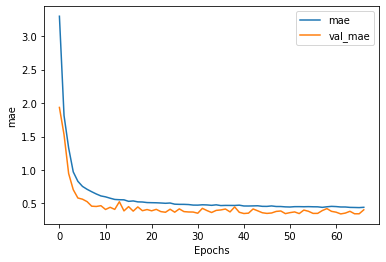

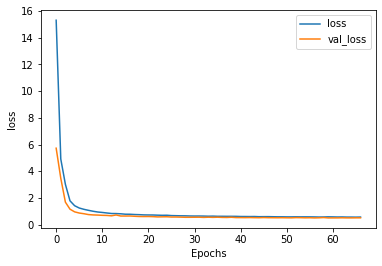

In [117]:
plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [118]:
scores = LSTM_model.evaluate(
    X_test, y_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=4, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

3360/3360 [==============================] - 6s 2ms/step - loss: 0.5313 - mae: 0.4080
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 53.13%
mae: 40.80%


In [119]:
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred_flattened = LSTM_y_pred.flatten(order='F')
LSTM_y_classified = [round(float(x)) for x in LSTM_y_pred_flattened]

print("First ten examples of the test set:")
print("Truth labels:", y_test.flatten(order='F')[:10])
print("Predicted labels:",LSTM_y_classified[:10])
print("Overall performance on all columns:\n", classification_report(y_test.flatten(order='F'), LSTM_y_classified))

First ten examples of the test set:
Truth labels: [2. 1. 2. 1. 4. 3. 4. 3. 3. 7.]
Predicted labels: [3, 1, 3, 1, 5, 4, 4, 3, 4, 1]
Overall performance on all columns:
               precision    recall  f1-score   support

         1.0       0.97      0.85      0.90      3691
         2.0       0.73      0.57      0.64      3921
         3.0       0.61      0.75      0.67      3952
         4.0       0.73      0.81      0.76      4161
         5.0       0.77      0.81      0.79      3786
         6.0       0.87      0.81      0.84      3748
         7.0       0.92      0.91      0.92      3621

    accuracy                           0.78     26880
   macro avg       0.80      0.79      0.79     26880
weighted avg       0.79      0.78      0.79     26880



# Ensemble

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.81      0.88      0.84       482
         3.0       0.72      0.70      0.71       510
         4.0       0.66      0.64      0.65       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.76      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 426  49   0   1   1   2]
 [  0  30 356 120   1   3   0]
 [  0   1  41 329 145   1   0]
 [  4   5  15  26 305 112   0]
 [  3  19  12   8   6 339  83]
 [ 10  26  20  12  10   6 368]]
Accuracy Score : 0.7633928571428571
Precision Score : 0.7618834616529019
Recall Score : 0.7633928571428571
F1 Score : 0.7623107

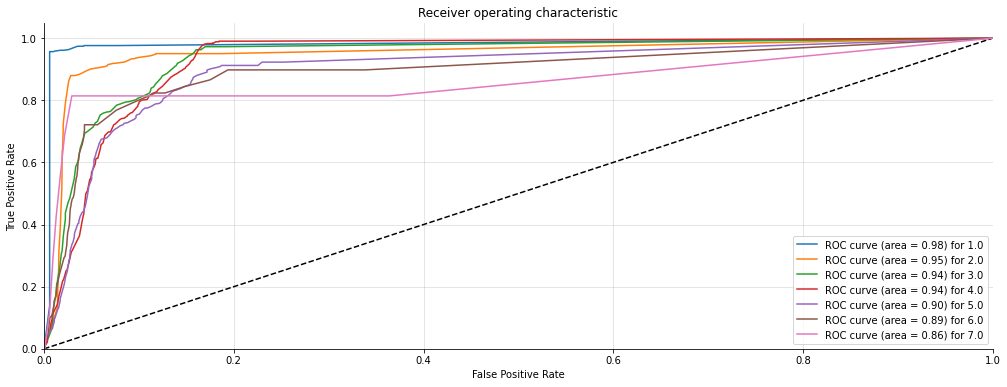

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.81      0.88      0.85       485
         3.0       0.73      0.71      0.72       501
         4.0       0.69      0.67      0.68       515
         5.0       0.71      0.74      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 427  49   0   1   5   0]
 [  0  27 354 118   2   0   0]
 [  0   3  43 343 124   2   0]
 [  3  13  17  15 342  70   0]
 [  5  17  15  14   6 384  43]
 [  9  18   7   4   4   2 408]]
Accuracy Score : 0.8035714285714286
Precision Score : 0.8031468206106565
Recall Score : 0.8035714285714286
F1 Score : 0.8030009182035

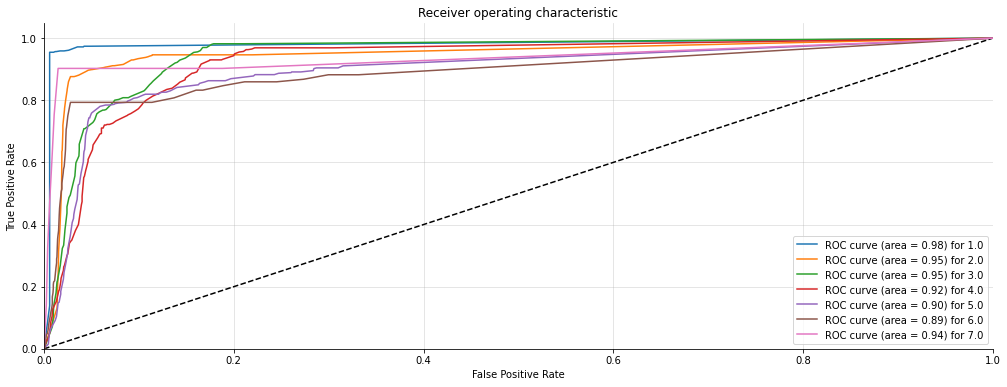

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.81      0.89      0.85       482
         3.0       0.72      0.71      0.71       506
         4.0       0.68      0.64      0.66       526
         5.0       0.66      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 427  49   0   1   0   2]
 [  0  27 357 119   0   3   0]
 [  0   3  43 335 145   0   0]
 [  2   5   7  20 307 117   0]
 [  6  17  23  10   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.7669642857142858
Precision Score : 0.7655286285585506
Recall Score : 0.7669642857142858
F1 Score : 0.76588968

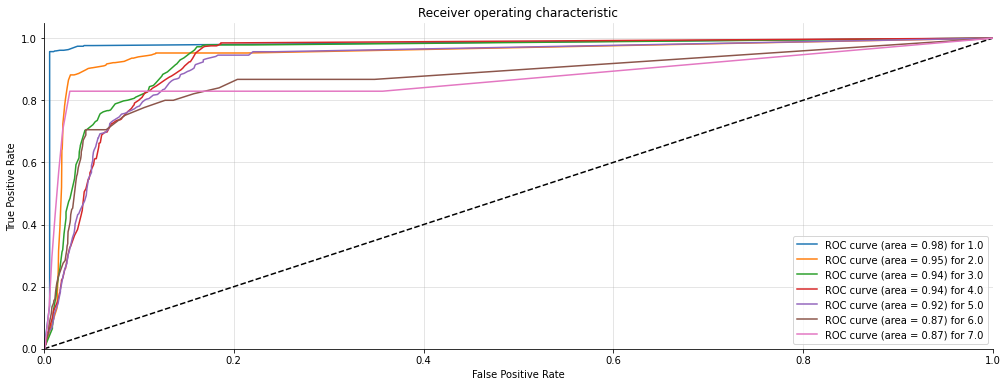

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.81      0.88      0.84       488
         3.0       0.73      0.70      0.71       506
         4.0       0.67      0.65      0.66       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.76      0.77      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 427  51   1   1   5   0]
 [  0  28 356 121   0   1   0]
 [  0   0  36 333 145   2   0]
 [  2   2  10  20 309 113   0]
 [  2  15  17   8   4 339  86]
 [ 13  34  21  16   9   4 365]]
Accuracy Score : 0.7651785714285714
Precision Score : 0.7643642845462538
Recall Score : 0.7651785714285714
F1 Score : 0.7645181123105

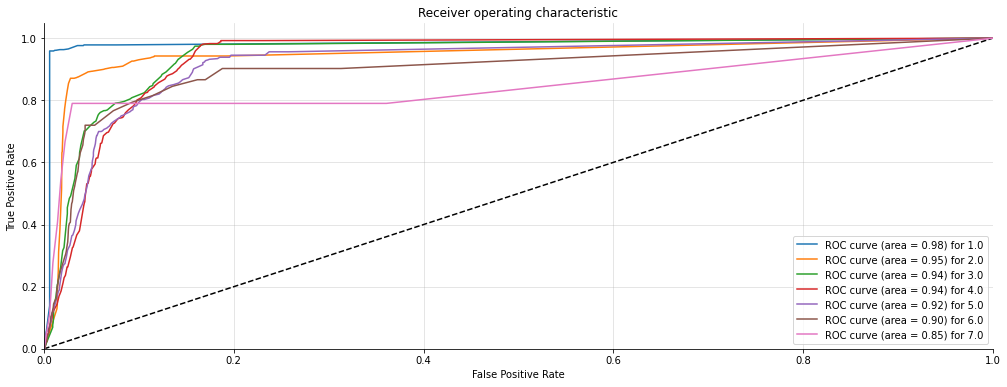

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.88      0.87       491
         3.0       0.83      0.80      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  8 430  47   2   1   3   0]
 [  7  28 392  58   2   0   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9092261904761905
Precision Score : 0.9090840034334206
Recall Score : 0.9092261904761905
F1 Score : 0.90911217445988

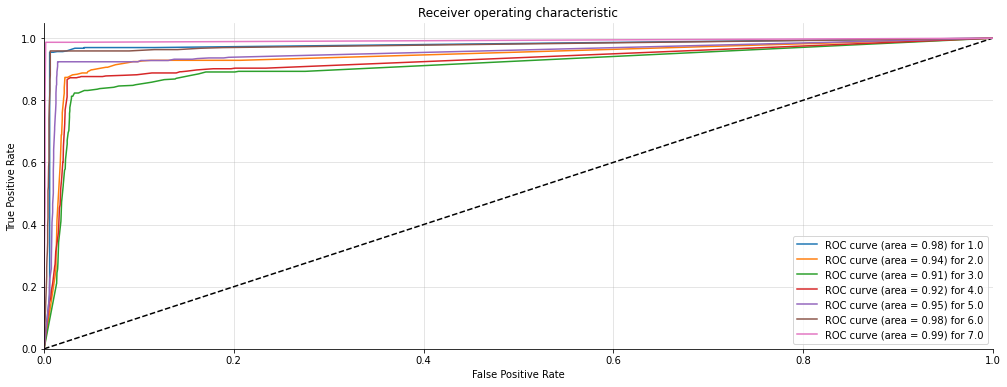

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.82      0.78      0.80       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  8 429  50   2   2   4   0]
 [  7  32 381  69   0   1   0]
 [  3  17  17 435  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8970238095238096
Precision Score : 0.8966891501664501
Recall Score : 0.8970238095238096
F1 Score : 0.89

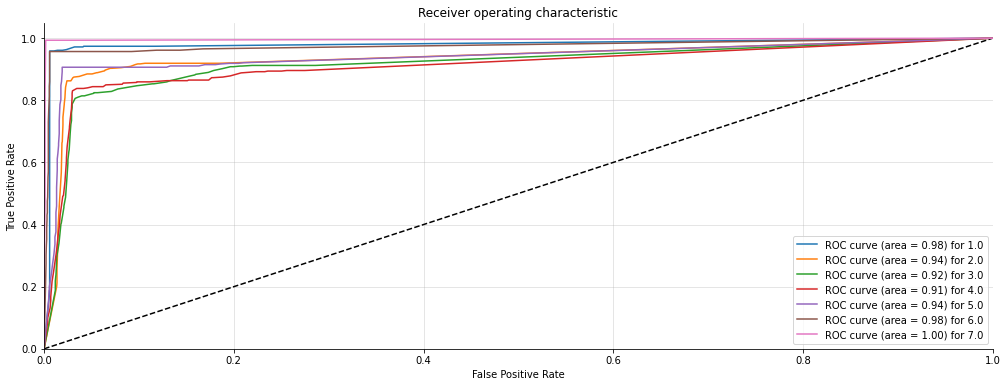

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.95       502
         3.0       0.94      0.94      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 477  17   2   1   0   0]
 [  0  14 447  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9702380952380952
Precision Score : 0.970227552562204
Recall Score : 0.9702380952380952
F1 Score : 0.97022233

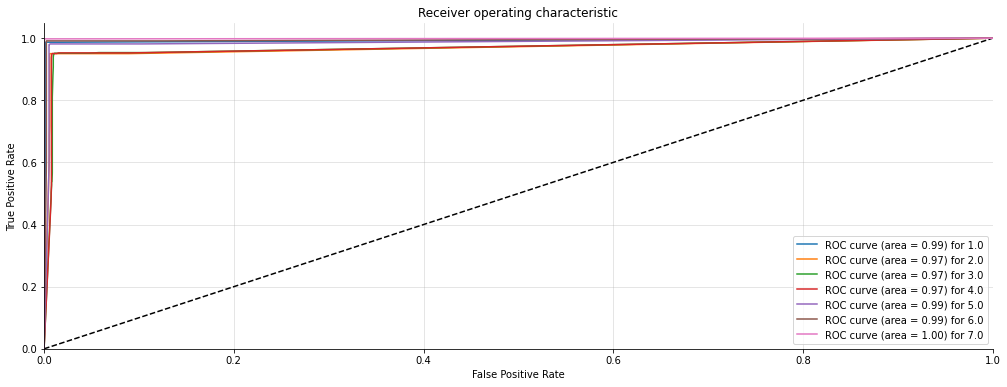

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


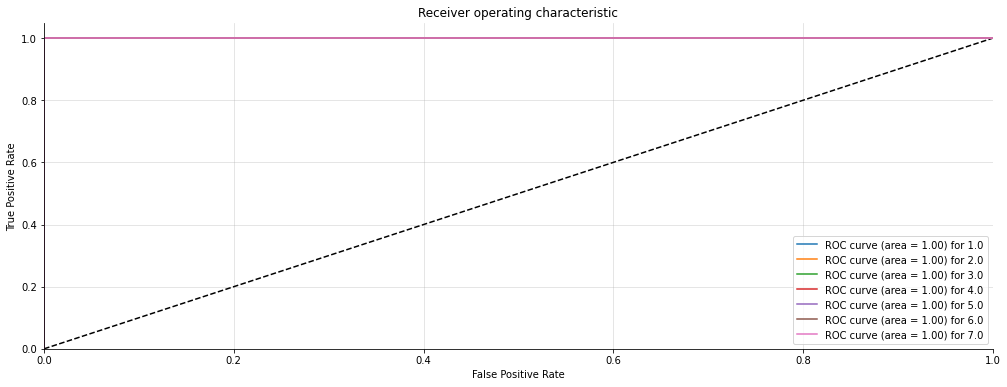

In [138]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def DTC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  DTC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.82      0.88      0.85       482
         3.0       0.73      0.71      0.72       510
         4.0       0.66      0.64      0.65       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.76      0.77      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  0 426  51   0   2   1   2]
 [  0  23 362 121   1   3   0]
 [  0   1  39 331 145   1   0]
 [  4   4  16  26 305 112   0]
 [  3  19  11   9   6 339  83]
 [ 10  26  20  12  10   6 368]]
Accuracy Score : 0.7657738095238096
Precision Score : 0.7646416412357415
Recall Score : 0.7657738095238096
F1 Score : 0.7649868

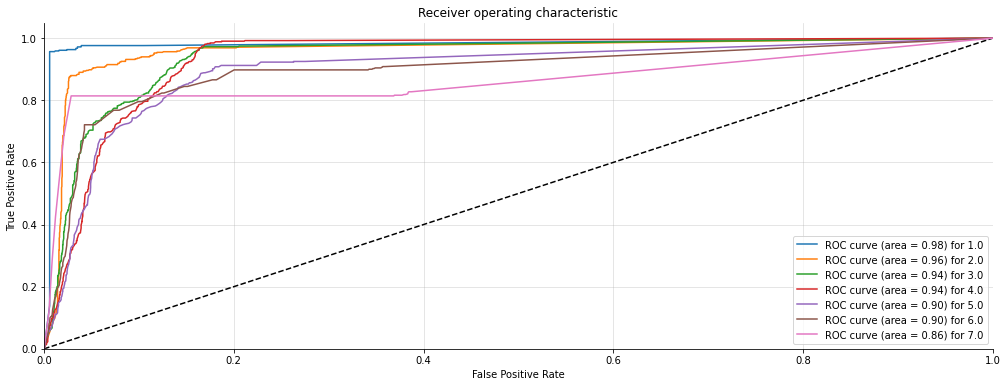

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.82      0.88      0.85       485
         3.0       0.73      0.71      0.72       501
         4.0       0.69      0.67      0.68       515
         5.0       0.71      0.74      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  0 429  48   1   2   5   0]
 [  0  23 354 122   2   0   0]
 [  0   2  42 345 124   2   0]
 [  3  13  17  15 342  70   0]
 [  5  17  15  14   6 384  43]
 [  9  18   6   5   4   2 408]]
Accuracy Score : 0.8047619047619048
Precision Score : 0.804624644680578
Recall Score : 0.8047619047619048
F1 Score : 0.80437016529106

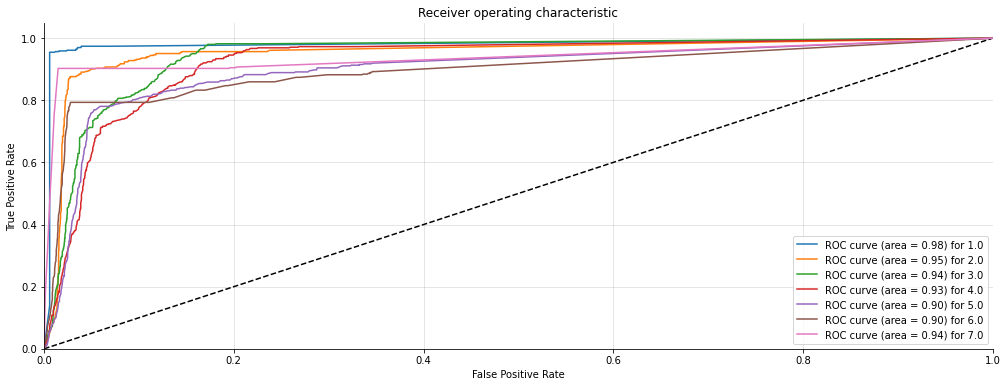

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.82      0.89      0.86       482
         3.0       0.73      0.71      0.72       506
         4.0       0.67      0.64      0.66       526
         5.0       0.66      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.82      0.83      0.82       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  0 430  48   0   1   0   3]
 [  0  23 357 120   0   3   3]
 [  0   3  41 337 145   0   0]
 [  2   4   8  20 307 117   0]
 [  6  17  22  11   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.768452380952381
Precision Score : 0.7671327758667668
Recall Score : 0.768452380952381
F1 Score : 0.7674612014

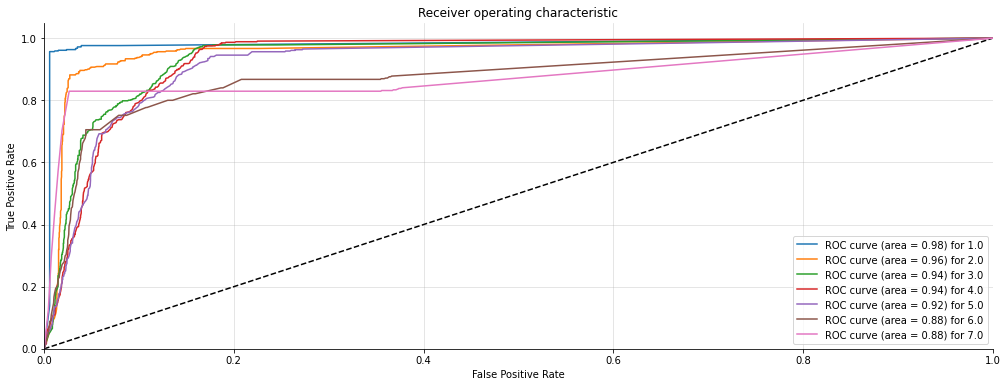

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.82      0.88      0.85       488
         3.0       0.73      0.71      0.72       506
         4.0       0.67      0.65      0.66       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  0 430  51   1   1   5   0]
 [  0  24 359 122   0   1   0]
 [  0   0  34 335 145   2   0]
 [  2   2  10  20 309 113   0]
 [  2  14  17   9   4 339  86]
 [ 13  34  21  16   9   4 365]]
Accuracy Score : 0.7675595238095239
Precision Score : 0.7669990239221808
Recall Score : 0.7675595238095239
F1 Score : 0.7670556724931

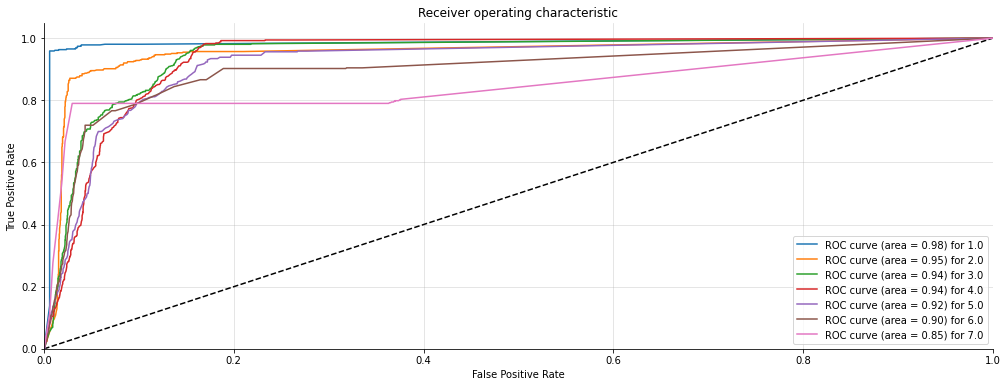

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.87      0.88      0.87       491
         3.0       0.83      0.80      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.95      0.96      0.95       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  5 431  46   4   1   4   0]
 [  7  24 392  59   2   3   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9095238095238095
Precision Score : 0.9093658535434518
Recall Score : 0.9095238095238095
F1 Score : 0.90939330162797

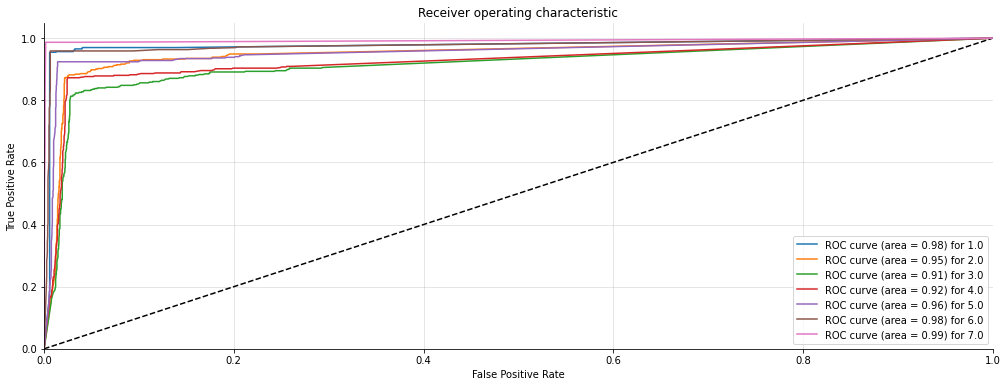

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.82      0.77      0.79       490
         4.0       0.82      0.84      0.83       519
         5.0       0.88      0.91      0.89       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  5 431  49   3   3   4   0]
 [  7  31 375  73   3   1   0]
 [  3  17  17 435  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8958333333333334
Precision Score : 0.8955502546351732
Recall Score : 0.8958333333333334
F1 Score : 0.89

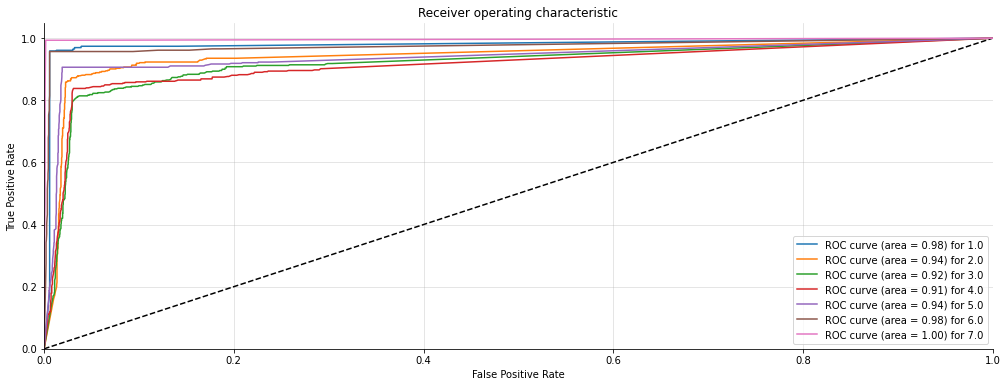

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.96       502
         3.0       0.94      0.95      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 477  17   2   1   0   0]
 [  0  12 449  13   0   0   0]
 [  0   1  11 501  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9711309523809524
Precision Score : 0.9711315158690603
Recall Score : 0.9711309523809524
F1 Score : 0.9711180

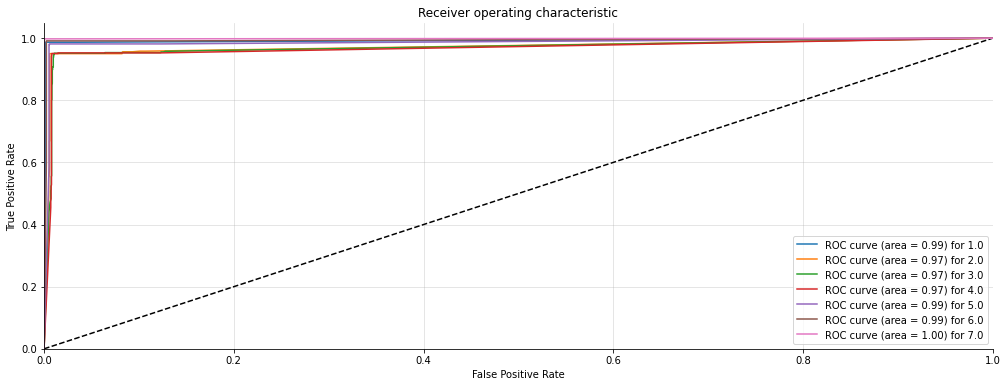

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


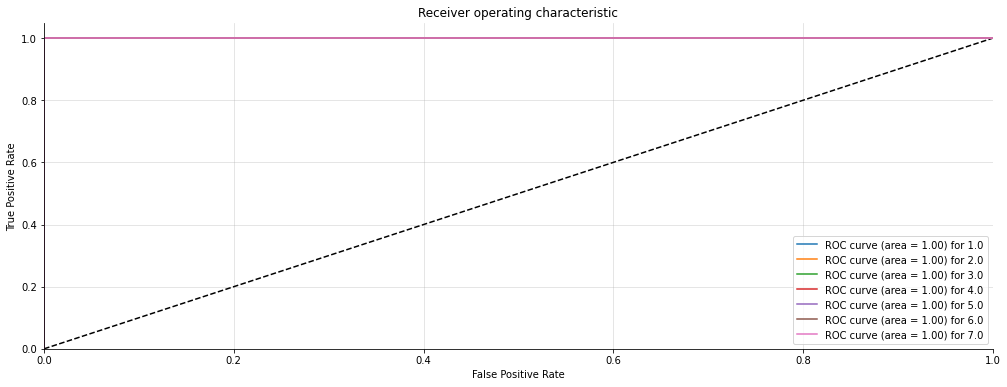

In [125]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def RFC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  RFC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.81      0.88      0.84       482
         3.0       0.72      0.70      0.71       510
         4.0       0.66      0.64      0.65       517
         5.0       0.65      0.65      0.65       467
         6.0       0.73      0.72      0.73       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.76      3360
   macro avg       0.76      0.77      0.76      3360
weighted avg       0.76      0.76      0.76      3360

Confusion Matrix: 
 [[442  20   0   0   0   0   0]
 [  3 426  49   0   1   1   2]
 [  0  30 356 120   1   3   0]
 [  0   1  41 329 145   1   0]
 [  4   5  15  26 305 112   0]
 [  3  19  12   8   6 339  83]
 [ 10  26  20  12  10   6 368]]
Accuracy Score : 0.7633928571428571
Precision Score : 0.7618834616529019
Recall Score : 0.7633928571428571
F1 Score : 0.7623107

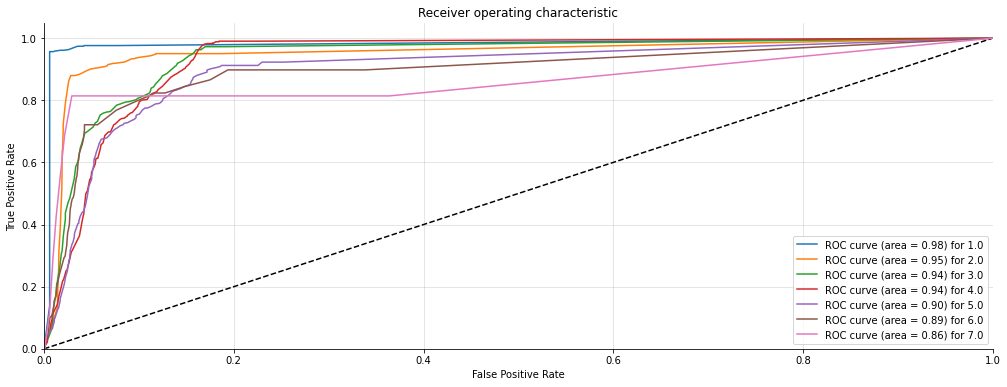

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.81      0.88      0.85       485
         3.0       0.73      0.71      0.72       501
         4.0       0.69      0.67      0.68       515
         5.0       0.71      0.74      0.73       460
         6.0       0.83      0.79      0.81       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.81      0.81      0.81      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  20   0   0   0   1   0]
 [  3 427  49   0   1   5   0]
 [  0  27 354 118   2   0   0]
 [  0   3  43 343 124   2   0]
 [  3  13  17  15 342  70   0]
 [  5  17  15  14   6 384  43]
 [  9  18   7   4   4   2 408]]
Accuracy Score : 0.8035714285714286
Precision Score : 0.8031468206106565
Recall Score : 0.8035714285714286
F1 Score : 0.8030009182035

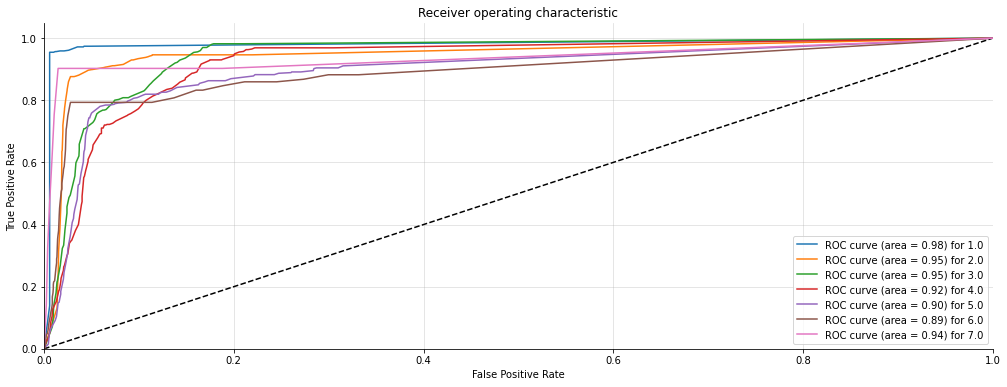

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       462
         2.0       0.81      0.89      0.85       482
         3.0       0.72      0.71      0.71       506
         4.0       0.68      0.64      0.66       526
         5.0       0.66      0.67      0.66       458
         6.0       0.73      0.71      0.72       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.77      0.77      0.77      3360

Confusion Matrix: 
 [[442  19   0   0   0   1   0]
 [  3 427  49   0   1   0   2]
 [  0  27 357 119   0   3   0]
 [  0   3  43 335 145   0   0]
 [  2   5   7  20 307 117   0]
 [  6  17  23  10   7 335  77]
 [  9  27  15  12   8   6 374]]
Accuracy Score : 0.7669642857142858
Precision Score : 0.7655286285585506
Recall Score : 0.7669642857142858
F1 Score : 0.76588968

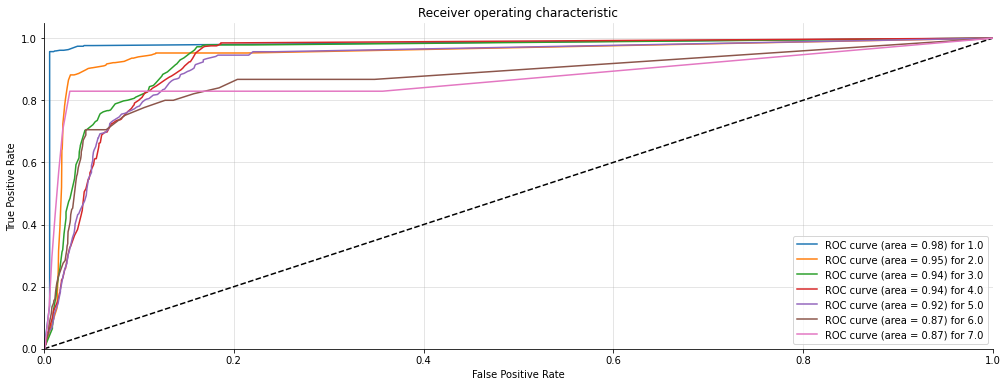

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.81      0.88      0.84       488
         3.0       0.73      0.70      0.71       506
         4.0       0.67      0.65      0.66       516
         5.0       0.66      0.68      0.67       456
         6.0       0.73      0.72      0.73       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.77      3360
   macro avg       0.77      0.77      0.77      3360
weighted avg       0.76      0.77      0.76      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 427  51   1   1   5   0]
 [  0  28 356 121   0   1   0]
 [  0   0  36 333 145   2   0]
 [  2   2  10  20 309 113   0]
 [  2  15  17   8   4 339  86]
 [ 13  34  21  16   9   4 365]]
Accuracy Score : 0.7651785714285714
Precision Score : 0.7643642845462538
Recall Score : 0.7651785714285714
F1 Score : 0.7645181123105

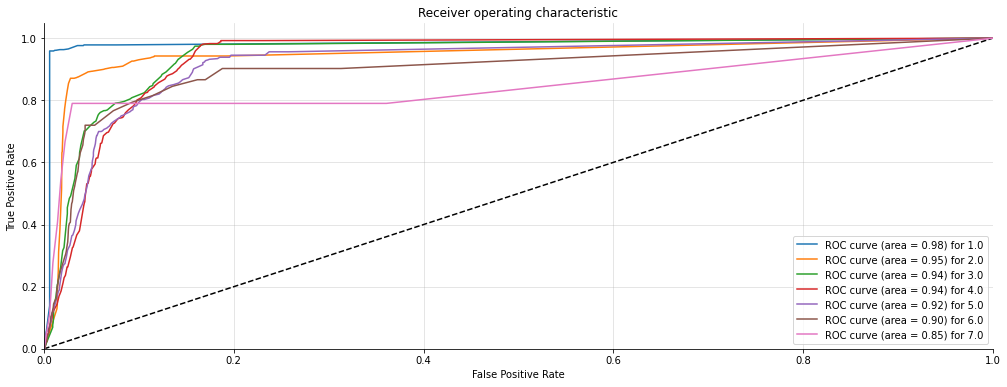

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       463
         2.0       0.86      0.88      0.87       491
         3.0       0.83      0.80      0.82       487
         4.0       0.86      0.87      0.87       518
         5.0       0.92      0.92      0.92       487
         6.0       0.96      0.96      0.96       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.91      3360
   macro avg       0.91      0.91      0.91      3360
weighted avg       0.91      0.91      0.91      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [  8 430  47   2   1   3   0]
 [  7  28 392  58   2   0   0]
 [  3  15  15 452  32   1   0]
 [  1   5  11   9 450  11   0]
 [  1   3   4   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.9092261904761905
Precision Score : 0.9090840034334206
Recall Score : 0.9092261904761905
F1 Score : 0.90911217445988

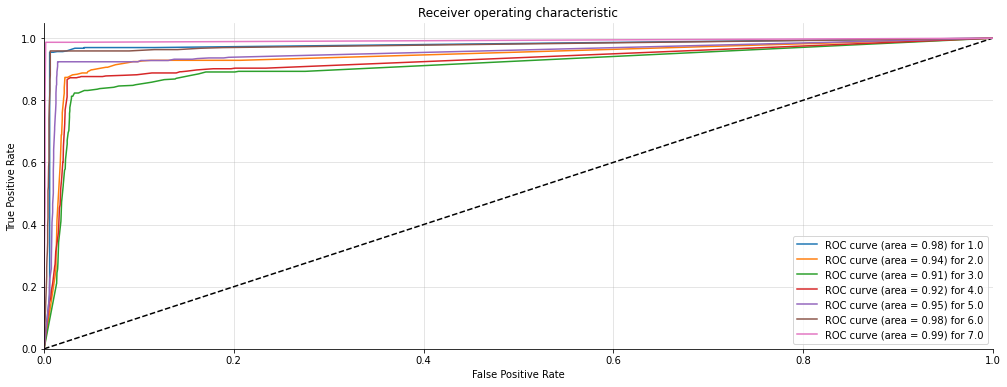

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       461
         2.0       0.85      0.87      0.86       495
         3.0       0.82      0.78      0.80       490
         4.0       0.83      0.84      0.83       519
         5.0       0.89      0.91      0.90       481
         6.0       0.96      0.96      0.96       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.90      0.90      0.90      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  8 429  50   2   2   4   0]
 [  7  32 381  69   0   1   0]
 [  3  17  17 435  47   0   0]
 [  1   7  11  15 436  11   0]
 [  1   2   4   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8970238095238096
Precision Score : 0.8966891501664501
Recall Score : 0.8970238095238096
F1 Score : 0.89

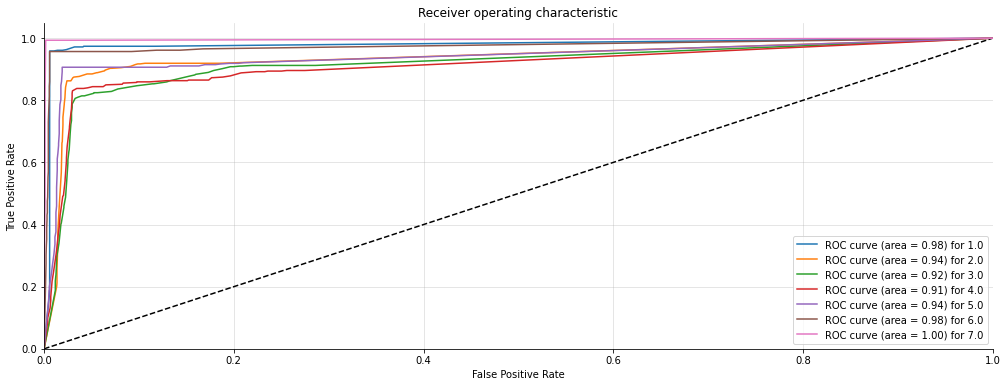

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       460
         2.0       0.96      0.95      0.95       502
         3.0       0.94      0.94      0.94       474
         4.0       0.96      0.95      0.95       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.99       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.97      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.97      0.97      0.97      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [  5 477  17   2   1   0   0]
 [  0  14 447  13   0   0   0]
 [  0   1  12 500  10   4   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9702380952380952
Precision Score : 0.970227552562204
Recall Score : 0.9702380952380952
F1 Score : 0.97022233

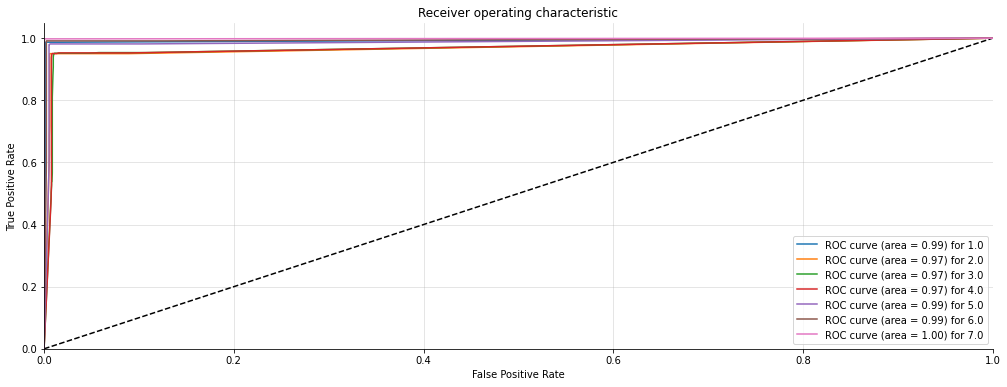

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       459
         2.0       1.00      1.00      1.00       496
         3.0       1.00      1.00      1.00       478
         4.0       1.00      1.00      1.00       523
         5.0       1.00      1.00      1.00       491
         6.0       1.00      1.00      1.00       462
         7.0       1.00      1.00      1.00       451

    accuracy                           1.00      3360
   macro avg       1.00      1.00      1.00      3360
weighted avg       1.00      1.00      1.00      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  0 496   0   0   0   0   0]
 [  0   0 478   0   0   0   0]
 [  0   0   0 523   0   0   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
(3360, 7) (3360, 7)


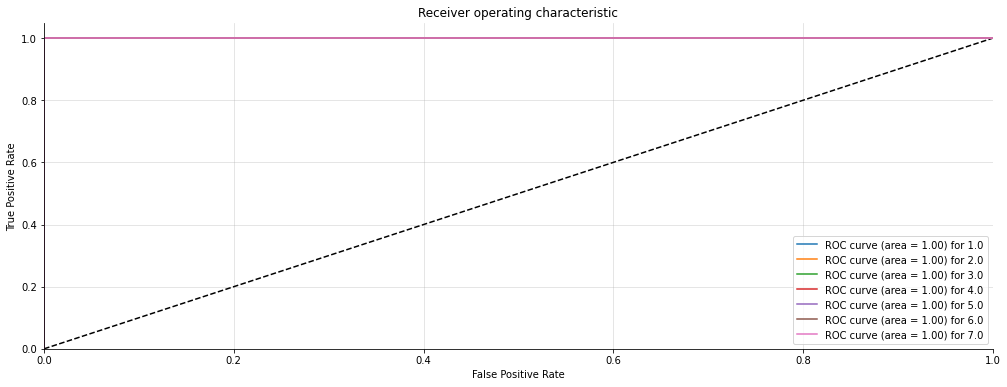

In [126]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def ETC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ETC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.61      0.60      0.60       462
         2.0       0.37      0.46      0.41       482
         3.0       0.34      0.30      0.31       510
         4.0       0.38      0.33      0.35       517
         5.0       0.27      0.34      0.30       467
         6.0       0.49      0.43      0.46       470
         7.0       0.72      0.65      0.68       452

    accuracy                           0.44      3360
   macro avg       0.45      0.44      0.45      3360
weighted avg       0.45      0.44      0.44      3360

Confusion Matrix: 
 [[279  53  48  20  33  19  10]
 [ 55 221  77  50  44  29   6]
 [ 45  95 151  90  73  42  14]
 [ 27  88  93 169 114  21   5]
 [ 23  50  54  96 159  83   2]
 [ 17  66  14   7  87 201  78]
 [ 15  18  13  11  90  13 292]]
Accuracy Score : 0.4380952380952381
Precision Score : 0.4487479727302784
Recall Score : 0.4380952380952381
F1 Score : 0.4410678

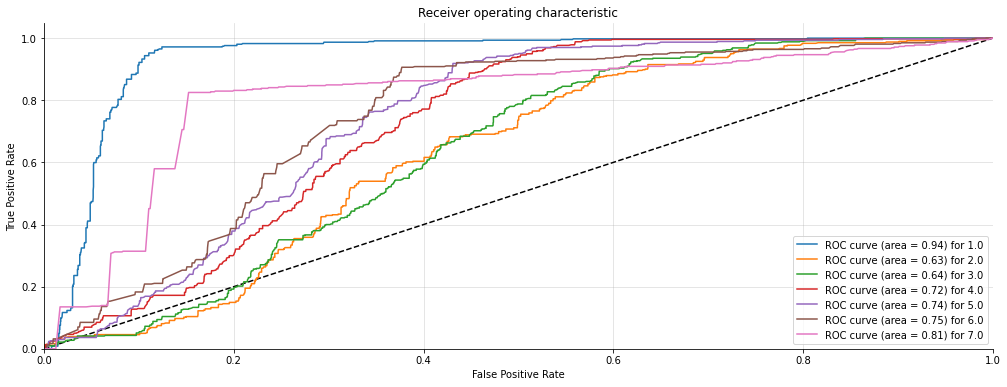

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.67      0.67      0.67       463
         2.0       0.27      0.36      0.31       485
         3.0       0.26      0.32      0.28       501
         4.0       0.34      0.32      0.33       515
         5.0       0.31      0.28      0.29       460
         6.0       0.47      0.39      0.42       484
         7.0       0.73      0.58      0.64       452

    accuracy                           0.41      3360
   macro avg       0.44      0.41      0.42      3360
weighted avg       0.43      0.41      0.42      3360

Confusion Matrix: 
 [[310  29  55  24  22  23   0]
 [ 59 176 106  46  53  30  15]
 [ 31 121 158  87  52  39  13]
 [ 14  87  98 163  98  50   5]
 [ 18  68  55 111 128  63  17]
 [ 23  64  65  38  59 187  48]
 [  8  97  74   6   3   4 260]]
Accuracy Score : 0.4113095238095238
Precision Score : 0.430935677247055
Recall Score : 0.4113095238095238
F1 Score : 0.41782555623433

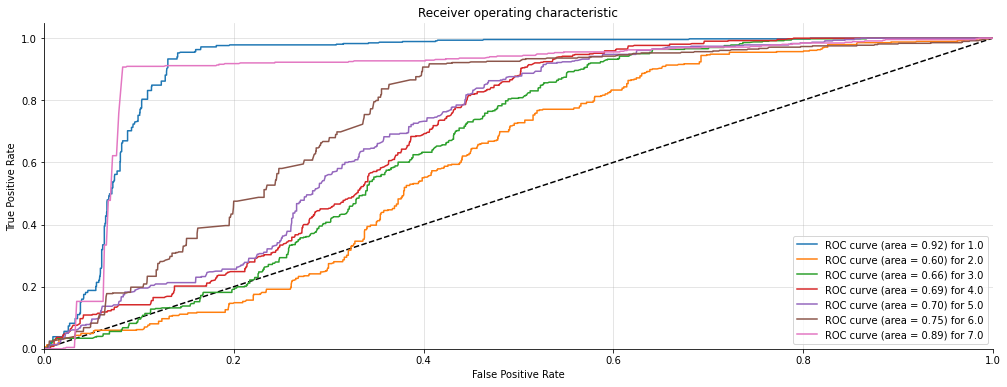

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.66      0.65      0.66       462
         2.0       0.31      0.46      0.37       482
         3.0       0.33      0.32      0.32       506
         4.0       0.36      0.29      0.32       526
         5.0       0.33      0.31      0.32       458
         6.0       0.44      0.38      0.41       475
         7.0       0.68      0.66      0.67       451

    accuracy                           0.43      3360
   macro avg       0.44      0.44      0.44      3360
weighted avg       0.44      0.43      0.43      3360

Confusion Matrix: 
 [[302  41  36  28  17  25  13]
 [ 53 221  84  49  28  36  11]
 [ 34 104 161  81  53  48  25]
 [ 18  96 100 152 111  36  13]
 [ 24  67  56  88 143  73   7]
 [ 15  89  41  14  63 181  72]
 [ 12  99  13   8  12   9 298]]
Accuracy Score : 0.43392857142857144
Precision Score : 0.44039726170307353
Recall Score : 0.43392857142857144
F1 Score : 0.43399

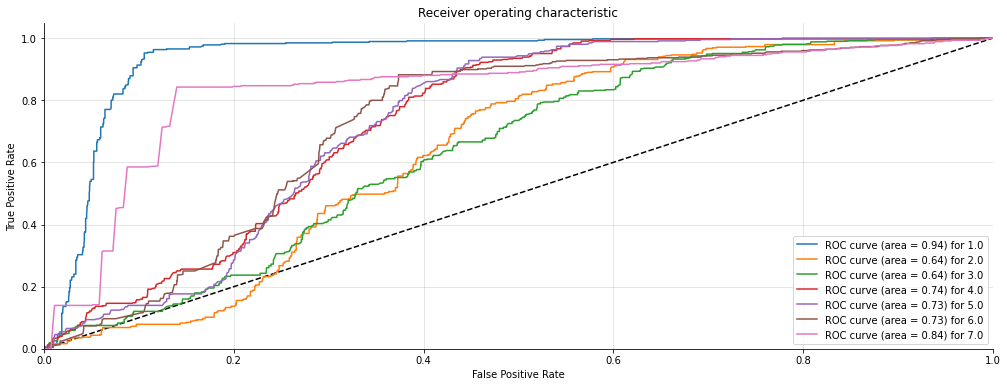

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.69      0.67      0.68       461
         2.0       0.38      0.47      0.42       488
         3.0       0.31      0.31      0.31       506
         4.0       0.40      0.33      0.36       516
         5.0       0.27      0.30      0.28       456
         6.0       0.48      0.50      0.49       471
         7.0       0.62      0.50      0.55       462

    accuracy                           0.44      3360
   macro avg       0.45      0.44      0.44      3360
weighted avg       0.45      0.44      0.44      3360

Confusion Matrix: 
 [[309  43  48  12  20  16  13]
 [ 48 230  72  39  51  36  12]
 [ 25 112 158  87  53  49  22]
 [ 17  82  84 169 102  50  12]
 [ 22  64  48  80 137  94  11]
 [  7  53  38  19  52 234  68]
 [ 17  28  70  19  93   6 229]]
Accuracy Score : 0.4363095238095238
Precision Score : 0.44688515589152655
Recall Score : 0.4363095238095238
F1 Score : 0.439121134325

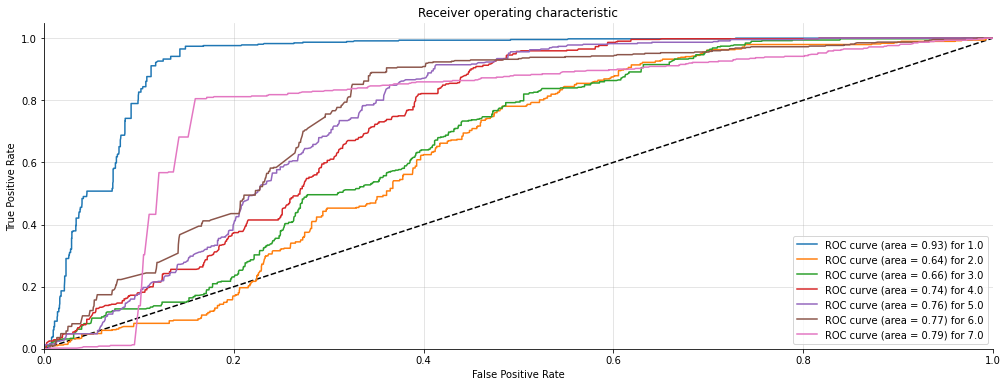

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.29      0.42      0.34       463
         2.0       0.27      0.16      0.20       491
         3.0       0.23      0.30      0.26       487
         4.0       0.24      0.23      0.23       518
         5.0       0.20      0.25      0.23       487
         6.0       0.38      0.22      0.28       462
         7.0       0.94      0.82      0.88       452

    accuracy                           0.34      3360
   macro avg       0.36      0.34      0.34      3360
weighted avg       0.36      0.34      0.34      3360

Confusion Matrix: 
 [[193  32  67  59  89  23   0]
 [112  78  72  76 120  28   5]
 [ 94  35 145  79  94  38   2]
 [105  36 116 117 106  32   6]
 [ 84  53  88  87 123  45   7]
 [ 84  59  61  77  73 103   5]
 [  2   1  75   1   0   1 372]]
Accuracy Score : 0.3366071428571429
Precision Score : 0.35624728892193297
Recall Score : 0.3366071428571429
F1 Score : 0.3384644754303

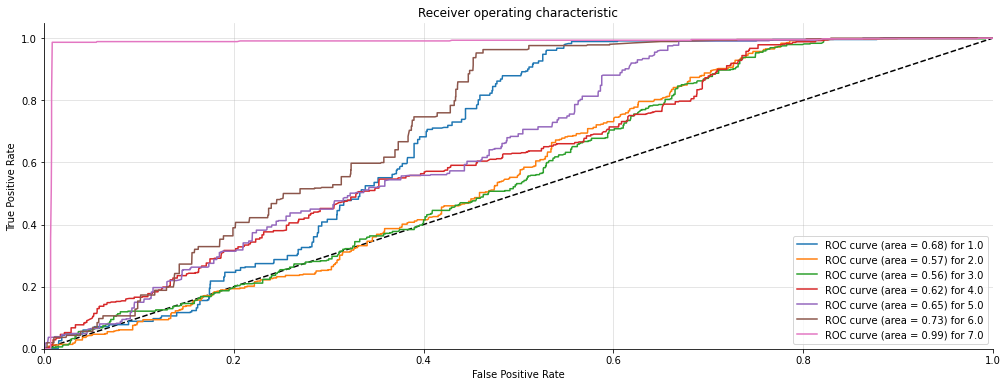

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.26      0.45      0.33       461
         2.0       0.18      0.18      0.18       495
         3.0       0.22      0.21      0.21       490
         4.0       0.29      0.17      0.22       519
         5.0       0.29      0.35      0.31       481
         6.0       0.35      0.20      0.25       465
         7.0       0.91      0.83      0.87       449

    accuracy                           0.33      3360
   macro avg       0.35      0.34      0.34      3360
weighted avg       0.35      0.33      0.33      3360

Confusion Matrix: 
 [[209  61  58  46  56  31   0]
 [162  91  70  44  90  33   5]
 [116  78 103  42  94  43  14]
 [125  88  90  90  91  30   5]
 [ 72  62  76  58 166  38   9]
 [121  61  75  32  78  93   5]
 [  0  74   2   0   1   0 372]]
Accuracy Score : 0.3345238095238095
Precision Score : 0.34842600708799615
Recall Score : 0.3345238095238095
F1 Score : 0.3

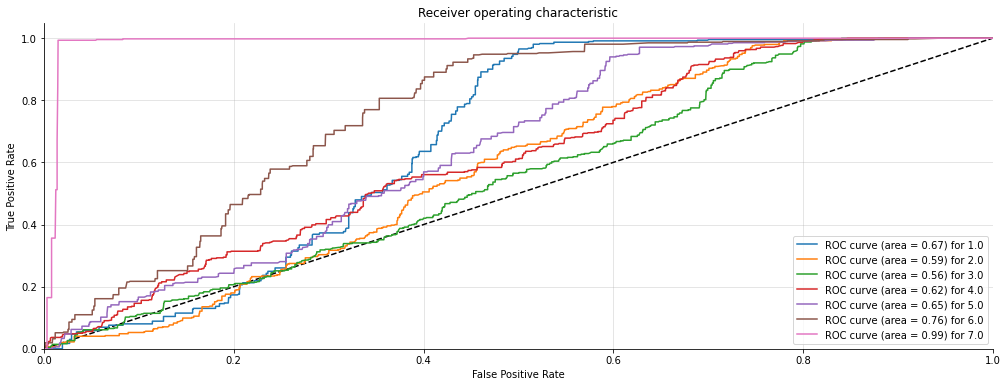

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.20      0.40      0.27       460
         2.0       0.28      0.13      0.18       502
         3.0       0.17      0.16      0.16       474
         4.0       0.21      0.21      0.21       527
         5.0       0.20      0.29      0.24       486
         6.0       0.23      0.11      0.15       459
         7.0       0.94      0.65      0.77       452

    accuracy                           0.27      3360
   macro avg       0.32      0.28      0.28      3360
weighted avg       0.31      0.27      0.28      3360

Confusion Matrix: 
 [[184  39  79  48  98  12   0]
 [180  67  46  55 128  26   0]
 [145  37  76  70 102  38   6]
 [166  12  74 111 121  41   2]
 [141  43  45  69 142  46   0]
 [109  41  49  96 104  49  11]
 [  0   0  86  72   1   0 293]]
Accuracy Score : 0.27440476190476193
Precision Score : 0.3135124486664562
Recall Score : 0.27440476190476193
F1 Score : 0.27758

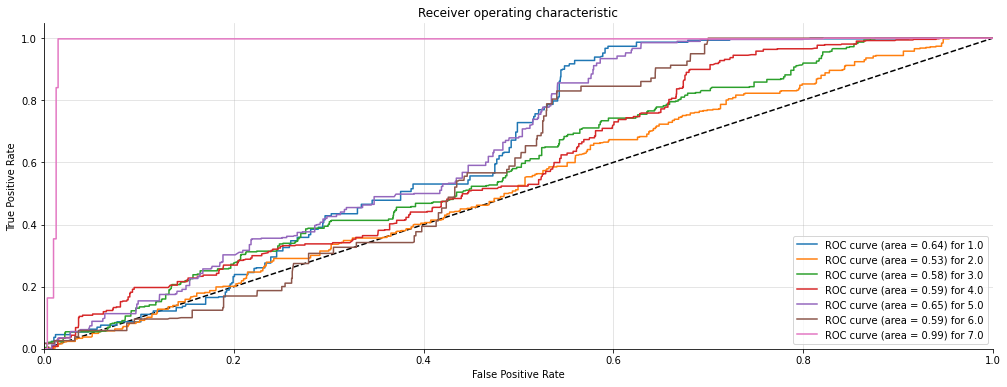

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.28      0.31      0.29       459
         2.0       0.25      0.14      0.18       496
         3.0       0.19      0.18      0.18       478
         4.0       0.18      0.27      0.21       523
         5.0       0.18      0.20      0.19       491
         6.0       0.20      0.23      0.21       462
         7.0       0.93      0.52      0.67       451

    accuracy                           0.26      3360
   macro avg       0.31      0.26      0.28      3360
weighted avg       0.31      0.26      0.27      3360

Confusion Matrix: 
 [[143  27  35 111  57  83   3]
 [ 93  68  49  97 106  78   5]
 [ 89  38  86  76  98  85   6]
 [ 65  46 100 139 108  64   1]
 [ 49  52  50 117  96 125   2]
 [ 77  40  66  92  79 108   0]
 [  0   0  71 146   0   0 234]]
Accuracy Score : 0.26011904761904764
Precision Score : 0.3077513487478742
Recall Score : 0.26011904761904764
F1 Score : 0.271821791

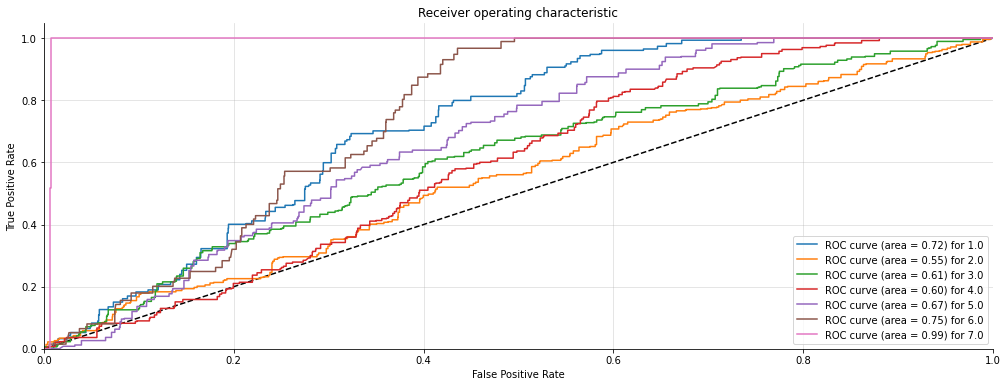

In [129]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def ADB(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = AdaBoostClassifier(n_estimators=500)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  ADB(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.55      0.87      0.68       462
         2.0       0.41      0.32      0.36       482
         3.0       0.36      0.27      0.31       510
         4.0       0.32      0.25      0.28       517
         5.0       0.32      0.29      0.31       467
         6.0       0.50      0.61      0.55       470
         7.0       0.80      0.82      0.81       452

    accuracy                           0.48      3360
   macro avg       0.47      0.49      0.47      3360
weighted avg       0.46      0.48      0.46      3360

Confusion Matrix: 
 [[400  13   2  14  13  20   0]
 [116 154  70  51  55  34   2]
 [ 65  80 140  92  64  62   7]
 [ 60  70  96 130 114  47   0]
 [ 37  31  54  90 137 118   0]
 [ 22  15  19  13  30 288  83]
 [ 22  12  10  15  13  11 369]]
Accuracy Score : 0.48154761904761906
Precision Score : 0.4606598740293812
Recall Score : 0.48154761904761906
F1 Score : 0.46314

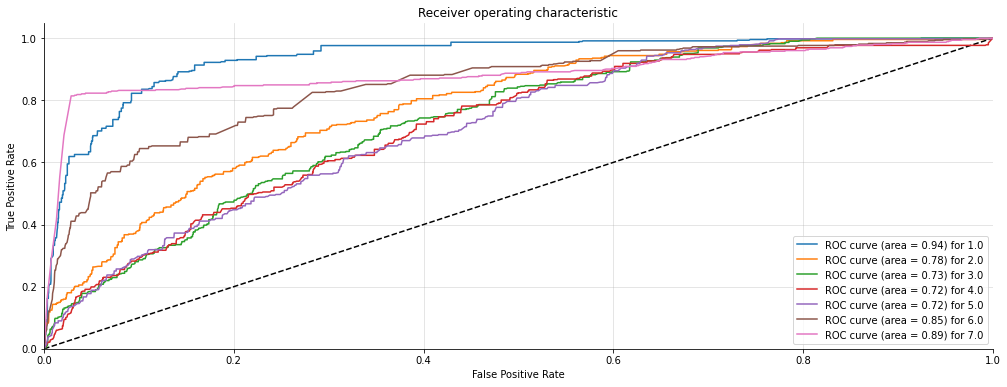

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.54      0.77      0.63       463
         2.0       0.41      0.36      0.38       485
         3.0       0.33      0.27      0.29       501
         4.0       0.38      0.31      0.34       515
         5.0       0.34      0.29      0.31       460
         6.0       0.58      0.71      0.64       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.51      3360
   macro avg       0.49      0.51      0.50      3360
weighted avg       0.49      0.51      0.49      3360

Confusion Matrix: 
 [[356  17  25  24  12  29   0]
 [ 85 173  79  43  68  36   1]
 [ 71 100 133  81  72  43   1]
 [ 76  66  78 161  89  45   0]
 [ 45  36  55  97 132  95   0]
 [ 18  21  24  19  16 343  43]
 [ 13  11   8   3   5   4 408]]
Accuracy Score : 0.5077380952380952
Precision Score : 0.48982953426811454
Recall Score : 0.5077380952380952
F1 Score : 0.493457495211

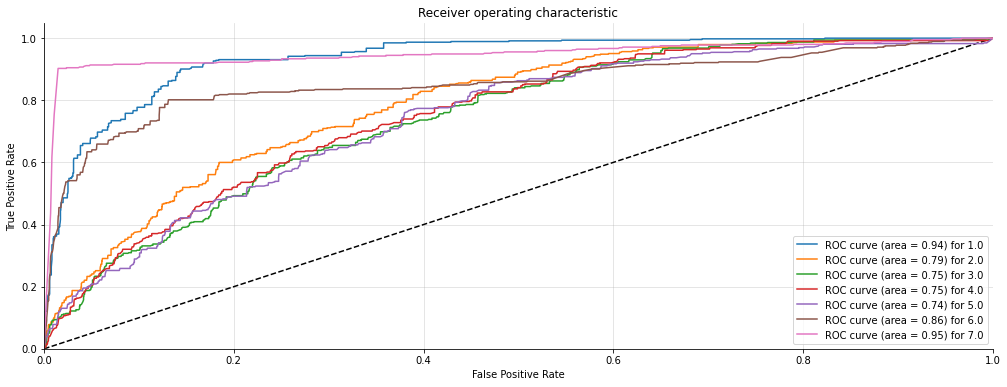

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.36      0.40      0.38       462
         2.0       0.21      0.37      0.27       482
         3.0       0.25      0.04      0.07       506
         4.0       0.37      0.20      0.26       526
         5.0       0.16      0.40      0.23       458
         6.0       0.34      0.20      0.25       475
         7.0       0.65      0.28      0.39       451

    accuracy                           0.27      3360
   macro avg       0.33      0.27      0.26      3360
weighted avg       0.33      0.27      0.26      3360

Confusion Matrix: 
 [[185 107  12  27 109  19   3]
 [ 97 180  14  38 123  22   8]
 [ 62 187  22  40 159  25  11]
 [ 53 143  26 105 171  19   9]
 [ 47 124  10  51 182  40   4]
 [ 53  83   3  18 190  95  33]
 [ 15  27   1   8 212  63 125]]
Accuracy Score : 0.26607142857142857
Precision Score : 0.33098526236575865
Recall Score : 0.26607142857142857
F1 Score : 0.26104

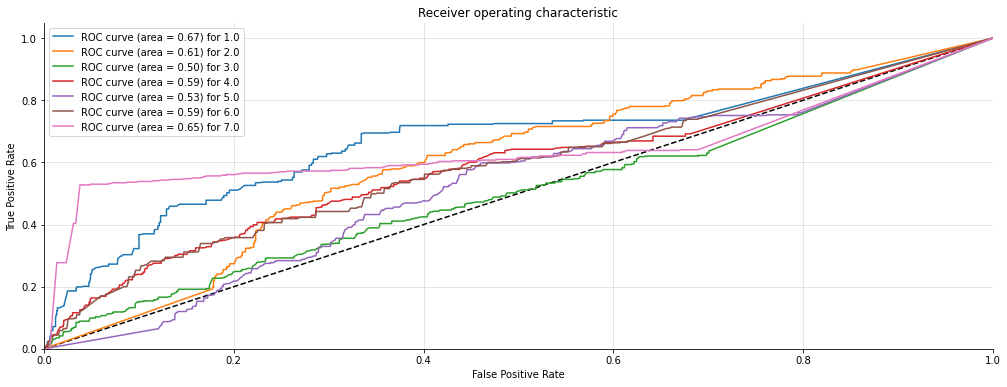

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.56      0.78      0.65       461
         2.0       0.39      0.34      0.37       488
         3.0       0.36      0.27      0.31       506
         4.0       0.30      0.27      0.28       516
         5.0       0.30      0.23      0.26       456
         6.0       0.48      0.65      0.55       471
         7.0       0.78      0.79      0.79       462

    accuracy                           0.47      3360
   macro avg       0.45      0.48      0.46      3360
weighted avg       0.45      0.47      0.45      3360

Confusion Matrix: 
 [[360  11  21  19  16  34   0]
 [ 73 168  89  63  49  42   4]
 [ 65  99 138  85  52  56  11]
 [ 60  83  74 138 105  56   0]
 [ 39  34  31 116 104 132   0]
 [ 24  14  12  19  11 305  86]
 [ 23  19  18  15  10  11 366]]
Accuracy Score : 0.4699404761904762
Precision Score : 0.45020699459484204
Recall Score : 0.4699404761904762
F1 Score : 0.453819562489

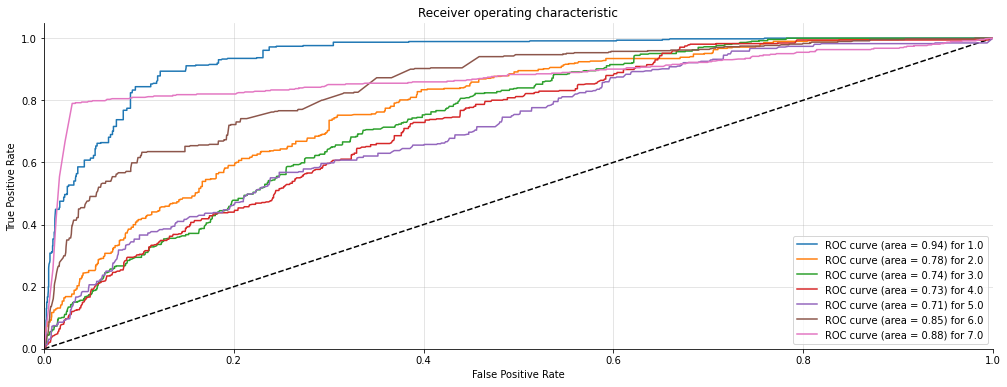

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.60      0.81      0.69       463
         2.0       0.48      0.43      0.45       491
         3.0       0.37      0.30      0.33       487
         4.0       0.51      0.40      0.45       518
         5.0       0.47      0.41      0.44       487
         6.0       0.69      0.93      0.79       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.60      3360
   macro avg       0.59      0.61      0.59      3360
weighted avg       0.58      0.60      0.58      3360

Confusion Matrix: 
 [[373  10  28  11  17  24   0]
 [ 89 210  67  46  56  23   0]
 [ 57  93 145  74  75  43   0]
 [ 57  65  70 207  74  45   0]
 [ 37  52  75  70 199  54   0]
 [ 10   8   2   1   5 431   5]
 [  1   1   0   0   1   3 446]]
Accuracy Score : 0.5985119047619047
Precision Score : 0.5803093193349323
Recall Score : 0.5985119047619047
F1 Score : 0.58274646071412

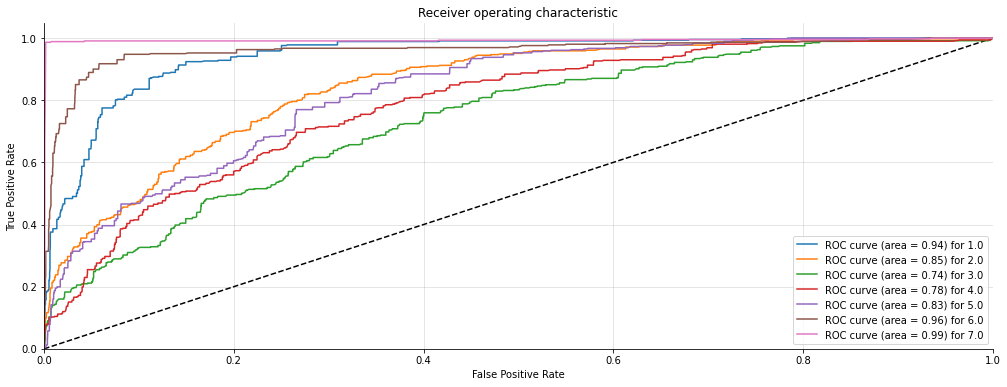

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.58      0.82      0.68       461
         2.0       0.46      0.44      0.45       495
         3.0       0.37      0.28      0.32       490
         4.0       0.45      0.31      0.37       519
         5.0       0.48      0.43      0.45       481
         6.0       0.66      0.87      0.75       465
         7.0       0.96      0.99      0.98       449

    accuracy                           0.58      3360
   macro avg       0.57      0.59      0.57      3360
weighted avg       0.56      0.58      0.56      3360

Confusion Matrix: 
 [[376  28  19  16   9  13   0]
 [ 80 218  51  51  58  36   1]
 [ 63 105 138  57  71  54   2]
 [ 77  71  77 160  77  56   1]
 [ 40  38  76  67 207  53   0]
 [ 10   9  14   1  13 405  13]
 [  1   0   0   1   0   1 446]]
Accuracy Score : 0.5803571428571429
Precision Score : 0.5594315622328604
Recall Score : 0.5803571428571429
F1 Score : 0.56

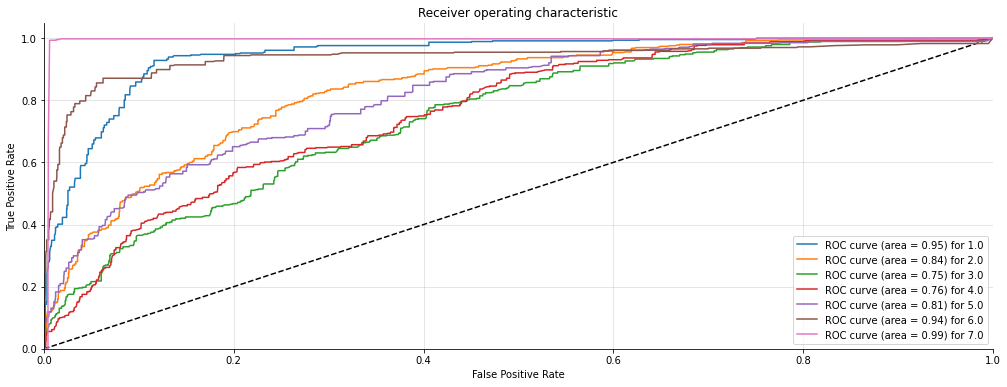

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.60      0.80      0.69       460
         2.0       0.54      0.45      0.49       502
         3.0       0.60      0.58      0.59       474
         4.0       0.50      0.38      0.43       527
         5.0       0.52      0.48      0.50       486
         6.0       0.76      0.94      0.84       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.65      3360
   macro avg       0.65      0.66      0.65      3360
weighted avg       0.64      0.65      0.64      3360

Confusion Matrix: 
 [[369  21  24  11  12  23   0]
 [ 80 226  65  52  59  20   0]
 [ 36  61 275  43  40  19   0]
 [ 70  59  59 202  98  39   0]
 [ 43  48  28 100 232  35   0]
 [ 17   5   6   0   1 430   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.6502976190476191
Precision Score : 0.6391251476815268
Recall Score : 0.6502976190476191
F1 Score : 0.6395422

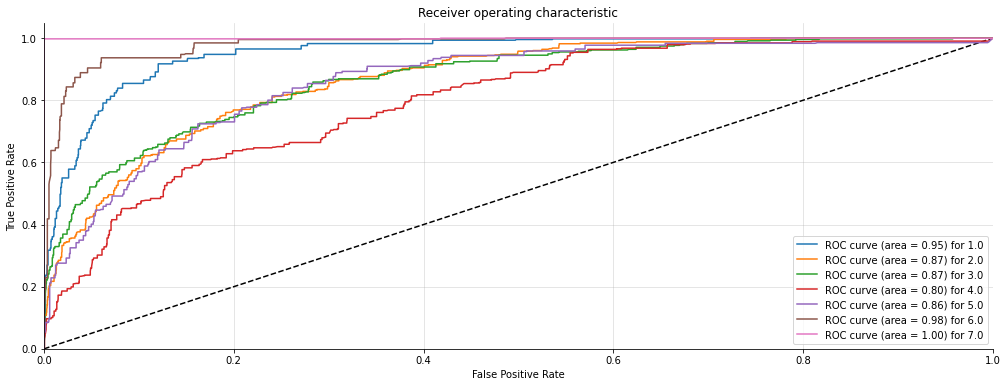

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.57      0.80      0.67       459
         2.0       0.57      0.47      0.52       496
         3.0       0.43      0.37      0.40       478
         4.0       0.45      0.33      0.38       523
         5.0       0.55      0.50      0.53       491
         6.0       0.71      0.93      0.81       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.62      3360
   macro avg       0.61      0.63      0.61      3360
weighted avg       0.61      0.62      0.61      3360

Confusion Matrix: 
 [[366   8  19  30   8  28   0]
 [ 78 234  53  57  49  25   0]
 [ 52  86 179  63  58  40   0]
 [ 66  61  94 174  84  44   0]
 [ 57  23  61  66 247  37   0]
 [ 18   0  13   0   0 431   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.6196428571428572
Precision Score : 0.6056631226113498
Recall Score : 0.6196428571428572
F1 Score : 0.60578163938

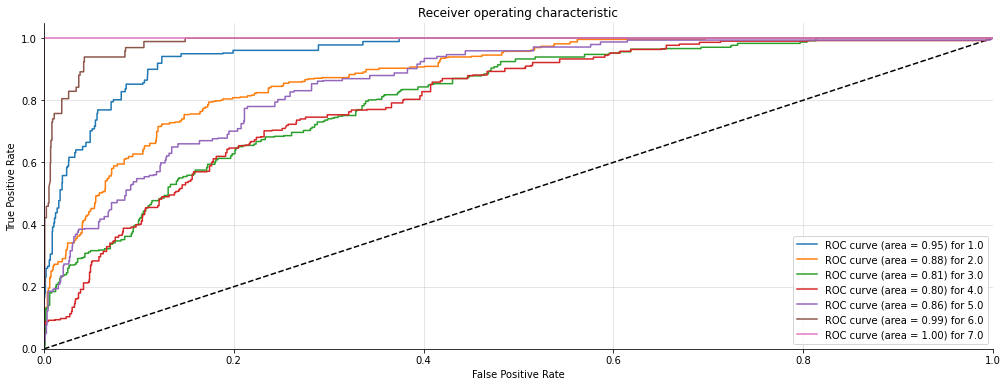

In [128]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def GBC(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  GBC(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))

In [133]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

For column: obstructive<==>supportive
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       462
         2.0       0.81      0.87      0.84       482
         3.0       0.71      0.68      0.70       510
         4.0       0.63      0.63      0.63       517
         5.0       0.65      0.63      0.64       467
         6.0       0.73      0.71      0.72       470
         7.0       0.81      0.81      0.81       452

    accuracy                           0.75      3360
   macro avg       0.75      0.76      0.76      3360
weighted avg       0.75      0.75      0.75      3360

Confusion Matrix: 
 [[442  19   1   0   0   0   0]
 [  1 421  52   2   2   1   3]
 [  4  29 349 121   2   5   0]
 [  4   1  44 325 138   5   0]
 [  4   4  16  40 293 110   0]
 [  3  17  12  10   9 336  83]
 [ 10  28  17  14   9   6 368]]
Accuracy Score : 0.7541666666666667
Precision Score : 0.7522359290186141
Recall Score : 0.7541666666666667
F1 Score : 0.7529636

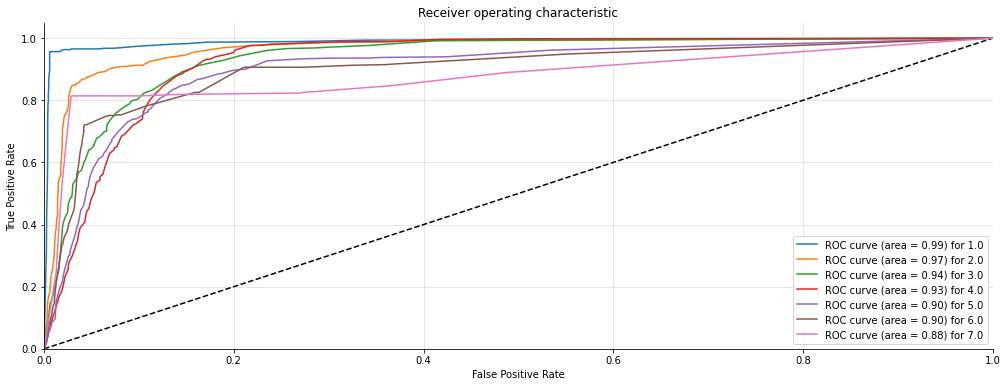

For column: complicated<==>easy
              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94       463
         2.0       0.84      0.86      0.85       485
         3.0       0.73      0.72      0.73       501
         4.0       0.68      0.66      0.67       515
         5.0       0.71      0.74      0.72       460
         6.0       0.81      0.79      0.80       484
         7.0       0.90      0.90      0.90       452

    accuracy                           0.80      3360
   macro avg       0.80      0.80      0.80      3360
weighted avg       0.80      0.80      0.80      3360

Confusion Matrix: 
 [[442  19   0   1   0   1   0]
 [  9 415  52   2   2   5   0]
 [  3  12 361 117   2   6   0]
 [  3   3  42 339 123   5   0]
 [  5  11  17  18 339  70   0]
 [  5  18  14  14   6 384  43]
 [  9  18   6   5   4   2 408]]
Accuracy Score : 0.8
Precision Score : 0.7990340532511636
Recall Score : 0.8
F1 Score : 0.7993871669784378
Accuracy: 0.797 (0.010)
(3

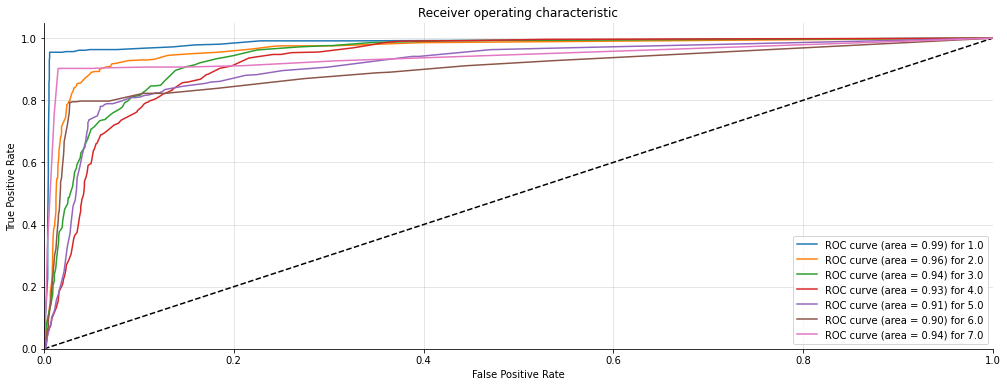

For column: inefficient<==>efficient
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       462
         2.0       0.83      0.86      0.84       482
         3.0       0.68      0.72      0.70       506
         4.0       0.67      0.59      0.63       526
         5.0       0.61      0.67      0.64       458
         6.0       0.70      0.65      0.67       475
         7.0       0.83      0.83      0.83       451

    accuracy                           0.75      3360
   macro avg       0.75      0.75      0.75      3360
weighted avg       0.75      0.75      0.75      3360

Confusion Matrix: 
 [[442  18   1   0   0   1   0]
 [  2 415  60   1   4   0   0]
 [  2  18 365 111   2   8   0]
 [  0   3  64 310 146   3   0]
 [  2   5   8  21 309 113   0]
 [  6  17  25   8  34 308  77]
 [ 10  27  14  12   8   6 374]]
Accuracy Score : 0.7508928571428571
Precision Score : 0.7507418791172208
Recall Score : 0.7508928571428571
F1 Score : 0.74992807

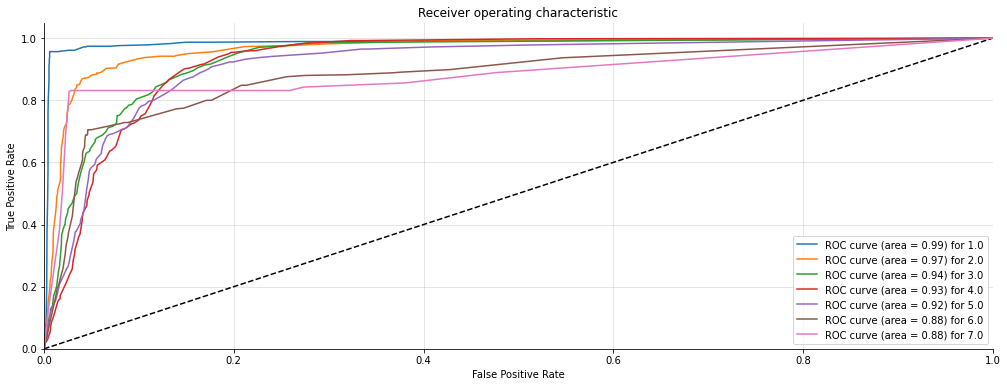

For column:  confusing<==>clear
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.81      0.86      0.83       488
         3.0       0.69      0.69      0.69       506
         4.0       0.67      0.60      0.64       516
         5.0       0.64      0.69      0.67       456
         6.0       0.72      0.70      0.71       471
         7.0       0.81      0.79      0.80       462

    accuracy                           0.75      3360
   macro avg       0.76      0.76      0.76      3360
weighted avg       0.75      0.75      0.75      3360

Confusion Matrix: 
 [[442  19   0   0   0   0   0]
 [  3 422  57   1   2   3   0]
 [  3  30 348 117   0   6   2]
 [  0   0  48 312 151   5   0]
 [  2   2  10  13 316 113   0]
 [  2  16  16   8  12 331  86]
 [ 13  34  22  14  10   4 365]]
Accuracy Score : 0.7547619047619047
Precision Score : 0.7538165445654711
Recall Score : 0.7547619047619047
F1 Score : 0.7537302401424

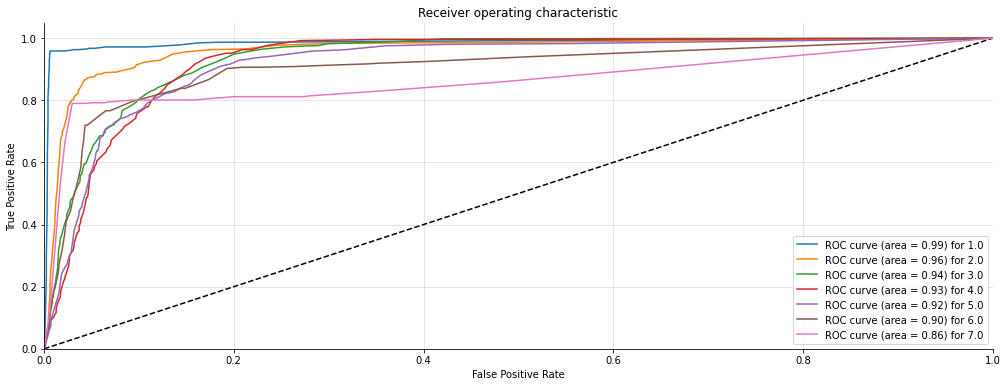

For column: boring<==>exciting
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95       463
         2.0       0.84      0.85      0.84       491
         3.0       0.80      0.77      0.79       487
         4.0       0.85      0.84      0.85       518
         5.0       0.90      0.92      0.91       487
         6.0       0.95      0.96      0.95       462
         7.0       0.99      0.99      0.99       452

    accuracy                           0.90      3360
   macro avg       0.90      0.90      0.90      3360
weighted avg       0.89      0.90      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   1   1   0]
 [ 11 416  51   8   2   3   0]
 [  7  39 375  58   5   3   0]
 [  3  16  24 436  35   4   0]
 [  1   5  11   9 450  11   0]
 [  1   4   3   2   4 443   5]
 [  0   0   2   0   1   3 446]]
Accuracy Score : 0.8952380952380953
Precision Score : 0.8946222239067946
Recall Score : 0.8952380952380953
F1 Score : 0.89484808830220

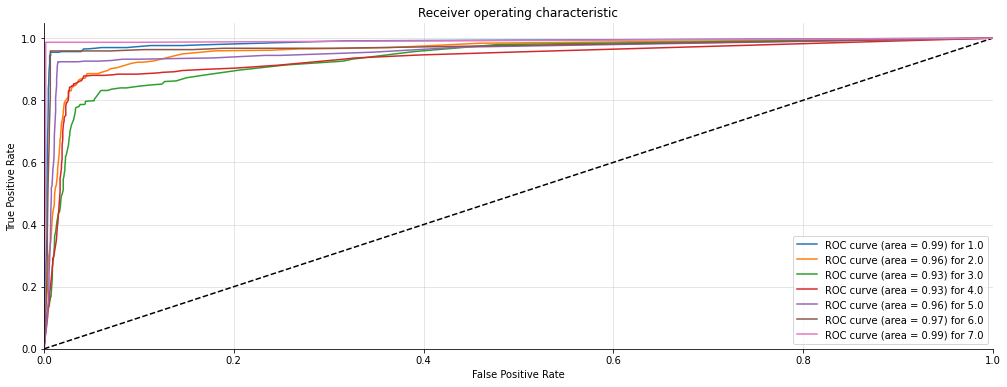

For column: not interesting<==>interesting
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       461
         2.0       0.84      0.84      0.84       495
         3.0       0.81      0.74      0.78       490
         4.0       0.81      0.83      0.82       519
         5.0       0.88      0.91      0.89       481
         6.0       0.94      0.96      0.95       465
         7.0       0.99      0.99      0.99       449

    accuracy                           0.89      3360
   macro avg       0.89      0.89      0.89      3360
weighted avg       0.89      0.89      0.89      3360

Confusion Matrix: 
 [[442  18   1   0   0   0   0]
 [  9 417  51   6   8   4   0]
 [ 10  32 363  76   1   8   0]
 [  3  19  17 430  47   3   0]
 [  1   8   9  16 436  11   0]
 [  1   3   3   2   6 445   5]
 [  0   0   2   0   0   1 446]]
Accuracy Score : 0.8866071428571428
Precision Score : 0.8857159630212378
Recall Score : 0.8866071428571428
F1 Score : 0.88

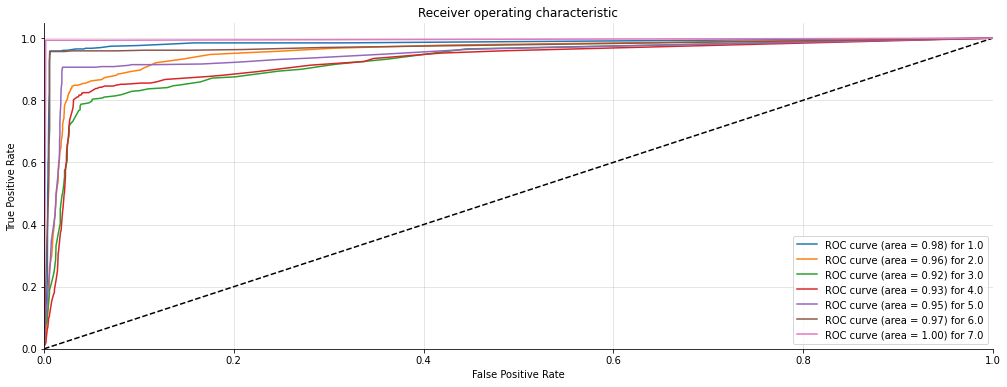

For column: conventional<==>inventive
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.98       460
         2.0       0.96      0.92      0.94       502
         3.0       0.94      0.94      0.94       474
         4.0       0.94      0.94      0.94       527
         5.0       0.97      0.98      0.97       486
         6.0       0.98      0.99      0.98       459
         7.0       1.00      1.00      1.00       452

    accuracy                           0.96      3360
   macro avg       0.97      0.97      0.97      3360
weighted avg       0.96      0.96      0.96      3360

Confusion Matrix: 
 [[454   6   0   0   0   0   0]
 [ 11 464  19   5   3   0   0]
 [  0  12 444  18   0   0   0]
 [  0   1  10 498  10   8   0]
 [  0   0   0   8 476   2   0]
 [  0   0   0   0   4 455   0]
 [  0   0   0   0   0   1 451]]
Accuracy Score : 0.9648809523809524
Precision Score : 0.9648313614314428
Recall Score : 0.9648809523809524
F1 Score : 0.9647841

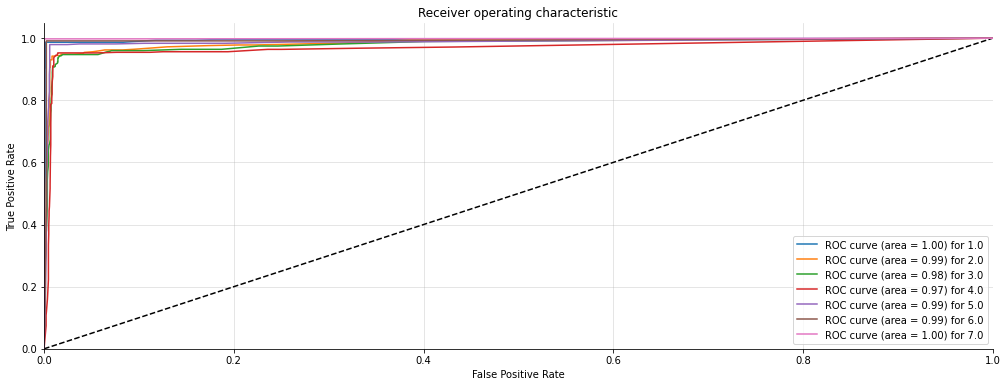

For column: usual<==>leading edge
              precision    recall  f1-score   support

         1.0       0.99      1.00      0.99       459
         2.0       1.00      0.99      0.99       496
         3.0       1.00      0.98      0.99       478
         4.0       0.99      0.98      0.99       523
         5.0       0.99      1.00      0.99       491
         6.0       0.98      1.00      0.99       462
         7.0       1.00      1.00      1.00       451

    accuracy                           0.99      3360
   macro avg       0.99      0.99      0.99      3360
weighted avg       0.99      0.99      0.99      3360

Confusion Matrix: 
 [[459   0   0   0   0   0   0]
 [  4 490   0   0   2   0   0]
 [  2   0 468   4   0   4   0]
 [  0   0   0 514   5   4   0]
 [  0   0   0   0 491   0   0]
 [  0   0   0   0   0 462   0]
 [  0   0   0   0   0   0 451]]
Accuracy Score : 0.9925595238095238
Precision Score : 0.9926408848521703
Recall Score : 0.9925595238095238
F1 Score : 0.99255245776

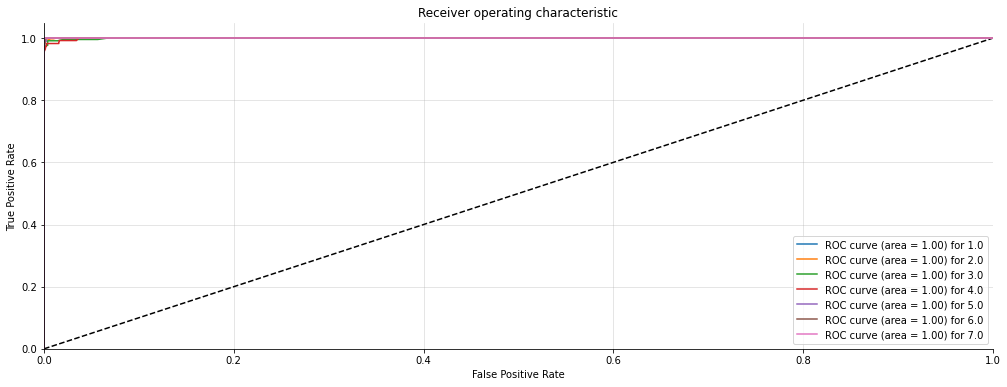

In [136]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix, accuracy_score
def BAG(X_train, X_test, y_train, y_test, n_classes, figsize=(8, 6)):
    model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)   
    model.fit(X_train, y_train)

    # predictions over test set
    predictions = [round(float(x)) for x in model.predict(X_test)]
    print((classification_report(y_test, predictions)))


    # calculating Accuracy Score, Precision Score, Recall Score and F1 Score
    print('Confusion Matrix: \n' ,confusion_matrix(y_test, predictions))
    print(f'Accuracy Score : {accuracy_score(y_test, predictions)}')
    print('Precision Score : ' + str(precision_score(y_test,predictions,average='weighted')))
    print('Recall Score : ' + str(recall_score(y_test,predictions,average='weighted')))
    print('F1 Score : ' + str(f1_score(y_test,predictions,average='weighted')))
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    plot_multiclass_roc(model, X_test, y_test, n_classes)

for i in range(8):
  print('For column:', df.columns[1:][i])
  n_classes = len(np.unique(df[df.columns[1:][i]]))
  BAG(X_train, X_test, y_train[:,i], y_test[:,i], n_classes, figsize=(8, 6))